Датасет, основанный на реальных данных (часть столбцов защифрована). Задача - найти закономерности и построить модели для предсказания того, чего предсказать возможно.

In [2]:
# Работа с данными 
import pandas as pd
import numpy as np

# Балансировка
from imblearn.over_sampling import SMOTE

# Разделение на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

# Классификаторы
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree

# Оценка качества
from yellowbrick.classifier import ROCAUC
from catboost.utils import get_confusion_matrix
# Визуалцияция результатов обучения
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from yellowbrick.classifier import ConfusionMatrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Загрузка данных

In [3]:
data = pd.read_csv(r'../data/feature_data_new_mini.csv')



/var/folders/9v/5p5m1vyn1l15r6g0mn4h76wc0000gn/T/ipykernel_58381/4206590392.py:1: DtypeWarning: Columns (113,116,119,122,125) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r'../data/feature_data_new_mini.csv')


In [4]:
goal = pd.read_csv(r'../data/goal_cipher.csv')
goal.head()

,Unnamed: 0,ser_loc,zns_loc,prs_loc,year_month,fail_place,fail_reason,fail_type,day
0,0,134,171.0,1.0,2021-01,Дуриан,Момордика,Мармеладный плод,12
1,3,134,166.0,1.0,2021-01,Маракуйя,Либерика,Салакка,12
2,4,240,1068.0,1.0,2021-01,Земляной орех,Абрикос,Пара-гуайява,5
3,7,240,2200.0,1.0,2021-01,Маракуйя,Гранат,Мармеладный плод,17
4,9,240,2734.0,1.0,2021-01,Земляной орех,Бананы,Гнетум гнемон,4


# Чистка данных

In [5]:
print(len(data.index))
data = data.drop_duplicates()
print(len(data.index))

167254
165691


# Сравнение дата-сетов

In [6]:
data.head()

,ser_loc,zns_loc,prs_loc,year_month,count_fail,107_repair_count,307_repair_count,308_repair_count,309_repair_count,521_repair_count,...,тл-2к_y,тл-2к1,эд118а,эд118б,эдп810,эк-810ч,экг-8ж,power,last_of_p_data,last_of_in_invent
0,107,3.0,1.0,2020-01-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0
1,107,3.0,1.0,2019-03-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0
2,107,4.0,1.0,2020-04-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,0.0,0.0
3,107,4.0,1.0,2020-06-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,6.0,6.0
4,107,4.0,1.0,2020-07-28,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,10.0,10.0


In [7]:
goal.head()

,Unnamed: 0,ser_loc,zns_loc,prs_loc,year_month,fail_place,fail_reason,fail_type,day
0,0,134,171.0,1.0,2021-01,Дуриан,Момордика,Мармеладный плод,12
1,3,134,166.0,1.0,2021-01,Маракуйя,Либерика,Салакка,12
2,4,240,1068.0,1.0,2021-01,Земляной орех,Абрикос,Пара-гуайява,5
3,7,240,2200.0,1.0,2021-01,Маракуйя,Гранат,Мармеладный плод,17
4,9,240,2734.0,1.0,2021-01,Земляной орех,Бананы,Гнетум гнемон,4


# Выделяем целевой массив

In [8]:
goal = goal[goal['fail_place'] == 'Дуриан']

# Готовим данные к объединению

In [9]:
goal = goal[['ser_loc','zns_loc','prs_loc','year_month', 'day']]
goal.columns = [x.lower() for x in goal.columns]
goal['day'] = [int(x) for x in goal['day']]
data.head()

data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m')
goal['year_month'] = pd.to_datetime(goal['year_month'], format='%Y-%m')

data['year_month'] = data['year_month'].dt.to_period('M')
goal['year_month'] = goal['year_month'].dt.to_period('M')

data.head()

,ser_loc,zns_loc,prs_loc,year_month,count_fail,107_repair_count,307_repair_count,308_repair_count,309_repair_count,521_repair_count,...,тл-2к_y,тл-2к1,эд118а,эд118б,эдп810,эк-810ч,экг-8ж,power,last_of_p_data,last_of_in_invent
0,107,3.0,1.0,2020-01,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0
1,107,3.0,1.0,2019-03,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0
2,107,4.0,1.0,2020-04,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,0.0,0.0
3,107,4.0,1.0,2020-06,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,6.0,6.0
4,107,4.0,1.0,2020-07,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,10.0,10.0


# Объединяем массивы

In [10]:
data_new = data.merge(goal, on = ['ser_loc','zns_loc','prs_loc','year_month'], how = 'outer')
data_new.head()

,ser_loc,zns_loc,prs_loc,year_month,count_fail,107_repair_count,307_repair_count,308_repair_count,309_repair_count,521_repair_count,...,тл-2к1,эд118а,эд118б,эдп810,эк-810ч,экг-8ж,power,last_of_p_data,last_of_in_invent,day
0,107,3.0,1.0,2020-01,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0,NaN
1,107,3.0,1.0,2019-03,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0,NaN
2,107,4.0,1.0,2020-04,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,0.0,0.0,NaN
3,107,4.0,1.0,2020-06,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,6.0,6.0,NaN
4,107,4.0,1.0,2020-07,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,10.0,10.0,NaN


In [11]:
data_new['day'].unique()

array([nan,  2., 25., 23.,  9.,  4., 17., 15., 19., 28., 12.,  5., 16.,
       18., 14., 20., 27.,  6.,  3.,  1., 11., 22., 26., 24., 10.,  8.,
       29., 31.,  7., 21., 30., 13.])

# Ищем и чистим плохие столбцы

In [12]:
data_new = data_new.dropna(subset = ['count_fail'])

In [13]:
i = 0
for col_name in data.columns:
    if col_name.find('_x_') == True:
        print(i)
    i += 1 

In [14]:
data_new = data_new.drop(columns=['date_repair_finish_y_1',
       'date_repair_finish_x_2',
       'date_repair_finish_y_2', 'date_repair_finish', 
       'date_repair_finish_x_1'])

In [15]:
data_new[data_new["day"]>0]

,ser_loc,zns_loc,prs_loc,year_month,count_fail,107_repair_count,307_repair_count,308_repair_count,309_repair_count,521_repair_count,...,тл-2к1,эд118а,эд118б,эдп810,эк-810ч,экг-8ж,power,last_of_p_data,last_of_in_invent,day
125,123,302.0,1.0,2020-12,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
126,123,302.0,1.0,2020-12,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
127,123,302.0,1.0,2020-12,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
128,123,302.0,1.0,2020-12,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
129,123,302.0,1.0,2020-12,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162260,640,104.0,2.0,2020-11,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2650.0,12.0,12.0,16.0
162272,640,106.0,1.0,2020-10,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2650.0,8.0,8.0,8.0
162413,640,119.0,2.0,2020-07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2250.0,6.0,6.0,13.0
162689,640,151.0,2.0,2020-07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2650.0,6.0,6.0,8.0


In [16]:
data_regression = data_new.copy()
data_classify = data_new.copy()
data_classify2 = data_new.copy()

# Регрессия, попытка построить регрессию на основе всех данных, предугадывающую день поломки на основе всех данных

50 -отсутствие отказа,будем делать так: прогнозировать дни поломок на основе данных с приборов. 50 мы выбрали потому, что это аномально большое значение,которого не существует в календарной системе.

In [17]:

def regression_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 

    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))
    try:
      mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
      print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    except:
      pass    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [18]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

from sklearn.metrics import confusion_matrix, roc_curve, plot_roc_curve, auc, ConfusionMatrixDisplay,roc_auc_score,r2_score,mean_squared_error,mean_absolute_error
import sklearn.datasets
import sklearn.metrics as metrics

In [19]:

data_regression['day'] = [x if x > 0 else 50 for x in data_new['day']]
data_regression = data_regression.set_index(['ser_loc','zns_loc','prs_loc','year_month'])

In [20]:
data_regression['day'].unique()

array([50.,  2., 25., 23.,  9.,  4., 17., 15., 19., 28., 12.,  5., 16.,
       18., 14., 20., 27.,  6.,  3.,  1., 11., 22., 26., 24., 10.,  8.,
       29., 31.,  7., 21., 30., 13.])

In [21]:

X =data_regression.drop(columns="day")
Y=data_regression["day"]
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=1)

In [22]:

#Дерево решений
model_tree = tree.DecisionTreeRegressor( random_state=42,max_depth=2).fit(X_train,np.ravel(y_train))

#Случайный лес
model_rf = RandomForestRegressor(n_estimators=100, 
                                  random_state=42, max_depth=40, bootstrap='false').fit(X_train, np.ravel(y_train))


#Градиентный бустинг
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0,
                                      max_depth=1, random_state=42).fit(X_train, np.ravel(y_train))


In [23]:
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)

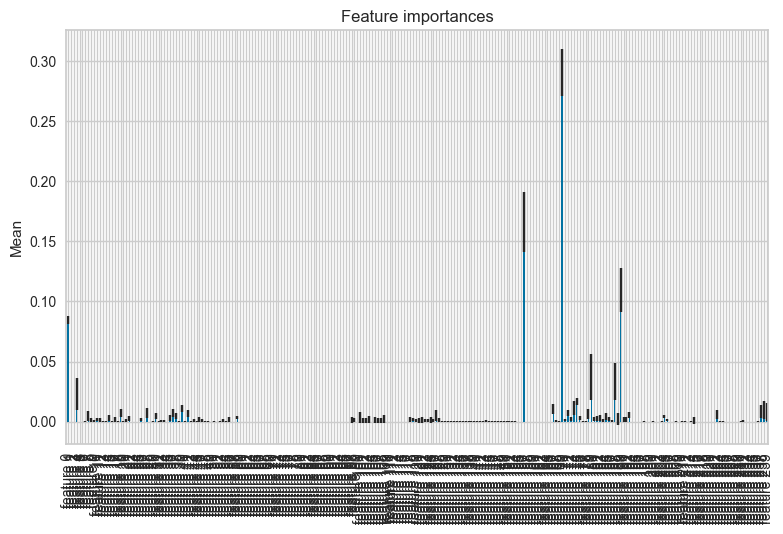

In [24]:

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean")
fig.tight_layout()

In [25]:
#Оценим получившиеся классификаторы

#Применим модель, чтобы посчитать модельные результаты
#Обучающая выборка
Y_tree_train=model_tree.predict(X_train)
Y_rf_train=model_rf.predict(X_train)
Y_gb_train=model_gb.predict(X_train)
#вероятности
Y_tree_train_proba=model_tree.predict(X_train)
Y_rf_train_proba=model_rf.predict(X_train)
Y_gb_train_proba=model_gb.predict(X_train)



#Тестовая выборка
Y_tree_tst=model_tree.predict(X_test)
Y_rf_tst=model_rf.predict(X_test)
Y_gb_tst=model_gb.predict(X_test)


#вероятности
Y_tree_tst_proba=model_tree.predict(X_test)
Y_rf_tst_proba=model_rf.predict(X_test)
Y_gb_tst_proba=model_gb.predict(X_test)


In [26]:

print("Метрики Деревья решений на тестовой выборке")
TREE_CLR=regression_results(y_test,Y_tree_tst)
print("-----------------------------")
print("Метрики Случайный лес на тестовой выборке")
RF_CLR=regression_results(y_test,Y_rf_tst)
print("-----------------------------")
print("Метрики Градиентный бустинг на тестовой выборке")
GB_CLR=regression_results(y_test,Y_gb_tst)
print("-----------------------------")




Метрики Деревья решений на тестовой выборке
explained_variance:  0.1735
mean_squared_log_error:  0.0258
r2:  0.1735
MAE:  1.0809
MSE:  18.3008
RMSE:  4.2779
-----------------------------
Метрики Случайный лес на тестовой выборке
explained_variance:  0.8473
mean_squared_log_error:  0.0052
r2:  0.8472
MAE:  0.1962
MSE:  3.3829
RMSE:  1.8393
-----------------------------
Метрики Градиентный бустинг на тестовой выборке
explained_variance:  0.3339
mean_squared_log_error:  0.0217
r2:  0.3339
MAE:  1.5294
MSE:  14.75
RMSE:  3.8406
-----------------------------


Наша модель ошибается всего лишь на 1 день,что довольно неплохо. У нас так же имеется хороший показатель R**2

# Нормализация данных

Для нормировки данных будем использовать самый популярный нормировщик - MinMaxScaler. Посмотрим, как изменятся результаты после нормировки.

In [27]:
from sklearn import preprocessing

In [28]:
scaler = preprocessing.MinMaxScaler()

In [29]:
names = data_regression.columns
d = scaler.fit_transform(data_regression)

scaled_df = pd.DataFrame(d, columns=names)
scaled_df.head()

,count_fail,107_repair_count,307_repair_count,308_repair_count,309_repair_count,521_repair_count,800_repair_count,801_repair_count,автоматический перевод в нр при превышении норм на то-2,износ тормозной колодки свыше допустимого,...,тл-2к1,эд118а,эд118б,эдп810,эк-810ч,экг-8ж,power,last_of_p_data,last_of_in_invent,day
0,0.142857,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.492424,0.000000,0.000000,1.0
1,0.142857,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.492424,0.000000,0.000000,1.0
2,0.142857,0.0,0.0,0.000000,0.0,0.0,0.0,0.166667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.466667,0.000000,0.000000,1.0
3,0.142857,0.0,0.0,0.000000,0.0,0.0,0.0,0.166667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.466667,0.063158,0.063158,1.0
4,0.142857,0.0,0.0,0.076923,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.466667,0.105263,0.105263,1.0


In [30]:

X =scaled_df.drop(columns="day")
Y=scaled_df["day"]
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=1)

In [31]:


#Дерево решений
model_tree = tree.DecisionTreeRegressor( random_state=42,max_depth=5).fit(X_train,np.ravel(y_train))

#Случайный лес
model_rf = RandomForestRegressor(n_estimators=100, 
                                  random_state=42, max_depth=40, bootstrap='false').fit(X_train, np.ravel(y_train))


#Градиентный бустинг
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0,
                                      max_depth=1, random_state=42).fit(X_train, np.ravel(y_train))


In [32]:
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)

In [33]:
#Оценим получившиеся классификаторы

#Применим модель, чтобы посчитать модельные результаты
#Обучающая выборка
Y_tree_train=model_tree.predict(X_train)
Y_rf_train=model_rf.predict(X_train)
Y_gb_train=model_gb.predict(X_train)
#вероятности
Y_tree_train_proba=model_tree.predict(X_train)
Y_rf_train_proba=model_rf.predict(X_train)
Y_gb_train_proba=model_gb.predict(X_train)



#Тестовая выборка
Y_tree_tst=model_tree.predict(X_test)
Y_rf_tst=model_rf.predict(X_test)
Y_gb_tst=model_gb.predict(X_test)


#вероятности
Y_tree_tst_proba=model_tree.predict(X_test)
Y_rf_tst_proba=model_rf.predict(X_test)
Y_gb_tst_proba=model_gb.predict(X_test)


In [34]:

print("Метрики Деревья решений на тестовой выборке")
TREE_CLR=regression_results(y_test,Y_tree_tst)
print("-----------------------------")
print("Метрики Случайный лес на тестовой выборке")
RF_CLR=regression_results(y_test,Y_rf_tst)
print("-----------------------------")
print("Метрики Градиентный бустинг на тестовой выборке")
GB_CLR=regression_results(y_test,Y_gb_tst)
print("-----------------------------")




Метрики Деревья решений на тестовой выборке
explained_variance:  0.5122
mean_squared_log_error:  0.0018
r2:  0.5122
MAE:  0.0123
MSE:  0.0045
RMSE:  0.0671
-----------------------------
Метрики Случайный лес на тестовой выборке
explained_variance:  0.8483
mean_squared_log_error:  0.0005
r2:  0.8482
MAE:  0.004
MSE:  0.0014
RMSE:  0.0374
-----------------------------
Метрики Градиентный бустинг на тестовой выборке
explained_variance:  0.3339
mean_squared_log_error:  0.0024
r2:  0.3339
MAE:  0.0312
MSE:  0.0061
RMSE:  0.0784
-----------------------------


# Нормализация через preproceccing normalize

Посмотрим, как изменится точность ргерессии при использовании нормы l2. Её обычно называют гребневой (Ridge) регрессией.Она нацелена на снижение весо каждого признака. В нашем датасете есть столбцы со значениями от 0 до несокльких миллионов. Поэтому нормализация жизненно необходима для данной рергрессии.

In [35]:
d = preprocessing.normalize(data_regression, axis=1)

scaled_df2 = pd.DataFrame(d, columns=names)
scaled_df2

,count_fail,107_repair_count,307_repair_count,308_repair_count,309_repair_count,521_repair_count,800_repair_count,801_repair_count,автоматический перевод в нр при превышении норм на то-2,износ тормозной колодки свыше допустимого,...,тл-2к1,эд118а,эд118б,эдп810,эк-810ч,экг-8ж,power,last_of_p_data,last_of_in_invent,day
0,4.311100e-07,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001401,0.000000,0.000000,0.000022
1,4.311100e-07,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001401,0.000000,0.000000,0.000022
2,4.311100e-07,0.0,0.0,0.000000e+00,0.0,0.0,0.0,4.311100e-07,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001328,0.000000,0.000000,0.000022
3,4.311100e-07,0.0,0.0,0.000000e+00,0.0,0.0,0.0,4.311100e-07,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001328,0.000003,0.000003,0.000022
4,4.311084e-07,0.0,0.0,4.311084e-07,0.0,0.0,0.0,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001328,0.000004,0.000004,0.000022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168825,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001196,0.000000,0.000000,0.000027
168826,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001196,0.000028,0.000028,0.000027
168827,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001196,0.000030,0.000030,0.000027
168828,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001196,0.000035,0.000035,0.000027


In [36]:

X =scaled_df2.drop(columns="day")
Y=scaled_df2["day"]

X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=1)

In [37]:

#Дерево решений
model_tree = tree.DecisionTreeRegressor( random_state=42,max_depth=5).fit(X_train,np.ravel(y_train))

#Случайный лес

model_rf = RandomForestRegressor(n_estimators=5, 
                                  random_state=42, max_depth=40, bootstrap='false').fit(X_train, np.ravel(y_train))


#Градиентный бустинг
model_gb = GradientBoostingRegressor(n_estimators=5, learning_rate=1.0,
                                      max_depth=1, random_state=42).fit(X_train, np.ravel(y_train))

In [38]:
#Оценим получившиеся классификаторы

#Применим модель, чтобы посчитать модельные результаты
#Обучающая выборка
Y_tree_train=model_tree.predict(X_train)
Y_rf_train=model_rf.predict(X_train)
Y_gb_train=model_gb.predict(X_train)
#вероятности
Y_tree_train_proba=model_tree.predict(X_train)
Y_rf_train_proba=model_rf.predict(X_train)
Y_gb_train_proba=model_gb.predict(X_train)



#Тестовая выборка
Y_tree_tst=model_tree.predict(X_test)
Y_rf_tst=model_rf.predict(X_test)
Y_gb_tst=model_gb.predict(X_test)


#вероятности
Y_tree_tst_proba=model_tree.predict(X_test)
Y_rf_tst_proba=model_rf.predict(X_test)
Y_gb_tst_proba=model_gb.predict(X_test)


In [39]:

print("Метрики Деревья решений на тестовой выборке")
TREE_CLR=regression_results(y_test,Y_tree_tst)
print("-----------------------------")
print("Метрики Случайный лес на тестовой выборке")
RF_CLR=regression_results(y_test,Y_rf_tst)
print("-----------------------------")
print("Метрики Градиентный бустинг на тестовой выборке")
GB_CLR=regression_results(y_test,Y_gb_tst)
print("-----------------------------")




Метрики Деревья решений на тестовой выборке
explained_variance:  0.8506
mean_squared_log_error:  0.0
r2:  0.8506
MAE:  0.0002
MSE:  0.0
RMSE:  0.0051
-----------------------------
Метрики Случайный лес на тестовой выборке
explained_variance:  0.9749
mean_squared_log_error:  0.0
r2:  0.9749
MAE:  0.0001
MSE:  0.0
RMSE:  0.0021
-----------------------------
Метрики Градиентный бустинг на тестовой выборке
explained_variance:  0.4673
r2:  0.4673
MAE:  0.0006
MSE:  0.0001
RMSE:  0.0096
-----------------------------


Ridge показала себя отлично, имеем R2 0.9749, что является очень высоким результатом.

# Регрессия ч2. Построим регрессию только по нашим поломкам

Слишком много значений равных 1 после нормализации

In [40]:
scaled_df["day"].value_counts()

1.000000    165275
0.387755       481
0.306122       297
0.469388       273
0.346939       255
0.530612       240
0.265306       188
0.428571       160
0.326531       159
0.367347       113
0.285714       109
0.040816       102
0.408163       100
0.489796        99
0.183673        97
0.448980        96
0.510204        95
0.204082        93
0.081633        67
0.102041        56
0.224490        55
0.142857        55
0.244898        54
0.020408        54
0.061224        53
0.122449        50
0.163265        48
0.571429        46
0.612245        20
0.551020        16
0.591837        12
0.000000        12
Name: day, dtype: int64

In [41]:
scaled_df3 = scaled_df[scaled_df["day"]!=1]

In [42]:
X =scaled_df3.drop(columns="day")
Y=scaled_df3["day"]
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=1)

In [43]:
scaled_df3["day"].value_counts()

0.387755    481
0.306122    297
0.469388    273
0.346939    255
0.530612    240
0.265306    188
0.428571    160
0.326531    159
0.367347    113
0.285714    109
0.040816    102
0.408163    100
0.489796     99
0.183673     97
0.448980     96
0.510204     95
0.204082     93
0.081633     67
0.102041     56
0.224490     55
0.142857     55
0.020408     54
0.244898     54
0.061224     53
0.122449     50
0.163265     48
0.571429     46
0.612245     20
0.551020     16
0.000000     12
0.591837     12
Name: day, dtype: int64

In [44]:


#Дерево решений
model_tree = tree.DecisionTreeRegressor( random_state=42,max_depth=5).fit(X_train,np.ravel(y_train))

#Случайный лес
model_rf = RandomForestRegressor(n_estimators=100, 
                                  random_state=42, max_depth=40, bootstrap='false').fit(X_train, np.ravel(y_train))


#Градиентный бустинг
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0,
                                      max_depth=1, random_state=42).fit(X_train, np.ravel(y_train))


In [45]:
#Оценим получившиеся классификаторы

#Применим модель, чтобы посчитать модельные результаты
#Обучающая выборка
Y_tree_train=model_tree.predict(X_train)
Y_rf_train=model_rf.predict(X_train)
Y_gb_train=model_gb.predict(X_train)
#вероятности
Y_tree_train_proba=model_tree.predict(X_train)
Y_rf_train_proba=model_rf.predict(X_train)
Y_gb_train_proba=model_gb.predict(X_train)



#Тестовая выборка
Y_tree_tst=model_tree.predict(X_test)
Y_rf_tst=model_rf.predict(X_test)
Y_gb_tst=model_gb.predict(X_test)


#вероятности
Y_tree_tst_proba=model_tree.predict(X_test)
Y_rf_tst_proba=model_rf.predict(X_test)
Y_gb_tst_proba=model_gb.predict(X_test)


In [46]:

print("Метрики Деревья решений на тестовой выборке")
TREE_CLR=regression_results(y_test,Y_tree_tst)
print("-----------------------------")
print("Метрики Случайный лес на тестовой выборке")
RF_CLR=regression_results(y_test,Y_rf_tst)
print("-----------------------------")
print("Метрики Градиентный бустинг на тестовой выборке")
GB_CLR=regression_results(y_test,Y_gb_tst)
print("-----------------------------")




Метрики Деревья решений на тестовой выборке
explained_variance:  0.2058
mean_squared_log_error:  0.0096
r2:  0.204
MAE:  0.0918
MSE:  0.0157
RMSE:  0.1254
-----------------------------
Метрики Случайный лес на тестовой выборке
explained_variance:  0.7077
mean_squared_log_error:  0.0034
r2:  0.7076
MAE:  0.0426
MSE:  0.0058
RMSE:  0.076
-----------------------------
Метрики Градиентный бустинг на тестовой выборке
explained_variance:  0.5783
r2:  0.5774
MAE:  0.0636
MSE:  0.0084
RMSE:  0.0914
-----------------------------


После балансировки упала точность R2,что было вполне ожидаемо. При уменьшении размера выборки снижается и качество предугадывания.

# Классификация ч.1

Давайте теперь сделаем классификацию. Скажем,что все поломки,которые произошли не из за нашей целевой пременной это 0,а если по нашей - то  1.

In [47]:
data_classify2['day'] = [1 if x > 0 else 0 for x in data_classify2['day']]
data_classify2 = data_classify2.set_index(['ser_loc','zns_loc','prs_loc','year_month'])

In [48]:
data_classify2['day'].value_counts()

0    165275
1      3555
Name: day, dtype: int64

In [49]:

X =data_classify2.drop(columns="day")
Y=data_classify2["day"]
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=1)

In [50]:

#Дерево решений
model_tree = tree.DecisionTreeClassifier(criterion='gini', random_state=42,max_depth=2).fit(X_train,np.ravel(y_train))

#Случайный лес
model_rf = RandomForestClassifier(n_estimators=10, 
                                  random_state=42, max_depth=40, bootstrap='false').fit(X_train, np.ravel(y_train))


#Градиентный бустинг
model_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                      max_depth=1, random_state=42).fit(X_train, np.ravel(y_train))

#Логистическая регрессия
model_logreg = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, np.ravel(y_train))
model_tree


DecisionTreeClassifier(max_depth=2, random_state=42)

In [51]:
#Оценим получившиеся классификаторы

#Применим модель, чтобы посчитать модельные результаты
#Обучающая выборка
Y_tree_train=model_tree.predict(X_train)
Y_rf_train=model_rf.predict(X_train)
Y_gb_train=model_gb.predict(X_train)
Y_logreg_train=model_logreg.predict(X_train)
#вероятности
Y_tree_train_proba=model_tree.predict_proba(X_train)
Y_rf_train_proba=model_rf.predict_proba(X_train)
Y_gb_train_proba=model_gb.predict_proba(X_train)
Y_logreg_train_proba=model_logreg.predict_proba(X_train)


#Тестовая выборка
Y_tree_tst=model_tree.predict(X_test)
Y_rf_tst=model_rf.predict(X_test)
Y_gb_tst=model_gb.predict(X_test)
Y_logreg_tst=model_logreg.predict(X_test)

#вероятности
Y_tree_tst_proba=model_tree.predict_proba(X_test)
Y_rf_tst_proba=model_rf.predict_proba(X_test)
Y_gb_tst_proba=model_gb.predict_proba(X_test)
Y_logreg_tst_proba=model_logreg.predict_proba(X_test)

Confusion Matrix Дерево решений


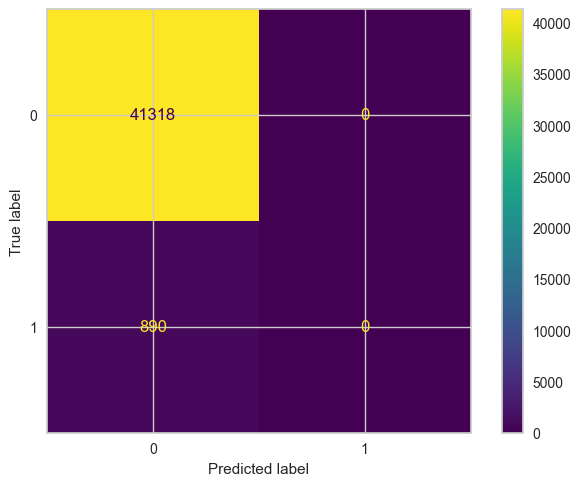

Confusion Matrix Случайный лес


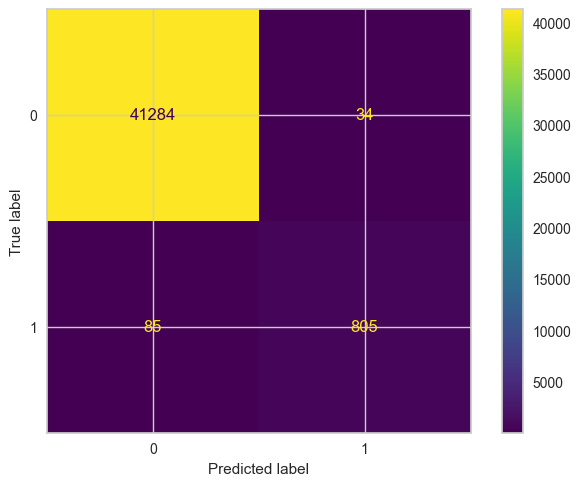

Confusion Matrix Градиентный бустинг


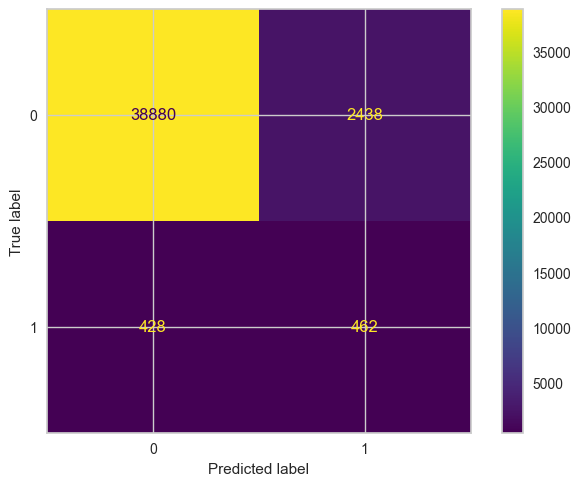

Confusion Matrix Логистическая регрессия


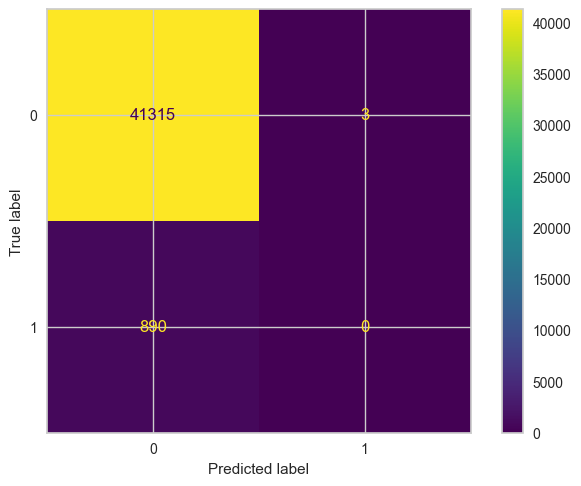

In [52]:
#Перед тем, как считать метрики посмотрим на Confusion Matrix

#Дерево
print('Confusion Matrix Дерево решений')
cm_tree = confusion_matrix(y_test, Y_tree_tst, labels=model_tree.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=model_tree.classes_)
disp_tree.plot()
plt.show()

#Случайный лес
print('Confusion Matrix Случайный лес')
cm_rf = confusion_matrix(y_test, Y_rf_tst, labels=model_rf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=model_rf.classes_)
disp_rf.plot()
plt.show()

#Градиентный бустинг
print('Confusion Matrix Градиентный бустинг')
cm_gb = confusion_matrix(y_test, Y_gb_tst, labels=model_gb.classes_)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=model_gb.classes_)
disp_gb.plot()
plt.show()

#Логистическая регрессия
print('Confusion Matrix Логистическая регрессия')
cm_logreg = confusion_matrix(y_test, Y_logreg_tst, labels=model_logreg.classes_)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=model_logreg.classes_)
disp_logreg.plot()
plt.show()

In [53]:
from sklearn.metrics import classification_report

TREE_CLR=classification_report(y_test,Y_tree_tst)
print("Метрики Деревья решений на тестовой выборке")
print(TREE_CLR)

RF_CLR=classification_report(y_test,Y_rf_tst)
print("Метрики Случайный лес на тестовой выборке")
print(RF_CLR)

GB_CLR=classification_report(y_test,Y_gb_tst)
print("Метрики Градиентный бустинг на тестовой выборке")
print(GB_CLR)

LOGREG_CLR=classification_report(y_test,Y_gb_tst)
print("Метрики Логистическая регрессия на тестовой выборке")
print(LOGREG_CLR)

Метрики Деревья решений на тестовой выборке
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     41318
           1       0.00      0.00      0.00       890

    accuracy                           0.98     42208
   macro avg       0.49      0.50      0.49     42208
weighted avg       0.96      0.98      0.97     42208

Метрики Случайный лес на тестовой выборке
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41318
           1       0.96      0.90      0.93       890

    accuracy                           1.00     42208
   macro avg       0.98      0.95      0.96     42208
weighted avg       1.00      1.00      1.00     42208

Метрики Градиентный бустинг на тестовой выборке
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     41318
           1       0.16      0.52      0.24       890

    accuracy                           0.93     

/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Проверка с нашими критериями

In [54]:
d = {'day':y_test}
Predict_test = pd.DataFrame(data=d)
Predict_test['predict'] = Y_rf_tst
print('Верно спрогнозированное событие, %: ', len(Predict_test[(Predict_test['predict'] == 1)&(Predict_test['day'] == 1)].index)/len(Predict_test[Predict_test['day'] == 1].index))
print('Верно спрогнозированное отсуствие события, %: ', len(Predict_test[(Predict_test['predict'] == 0)&(Predict_test['day'] == 0)].index)/len(Predict_test[Predict_test['day'] == 0].index))

Верно спрогнозированное событие, %:  0.9044943820224719
Верно спрогнозированное отсуствие события, %:  0.9991771140907111


In [55]:
d = {'day':y_test}
Predict_test = pd.DataFrame(data=d)
Predict_test['predict'] = Y_gb_tst
print('Верно спрогнозированное событие, %: ', len(Predict_test[(Predict_test['predict'] == 1)&(Predict_test['day'] == 1)].index)/len(Predict_test[Predict_test['day'] == 1].index))
print('Верно спрогнозированное отсуствие события, %: ', len(Predict_test[(Predict_test['predict'] == 0)&(Predict_test['day'] == 0)].index)/len(Predict_test[Predict_test['day'] == 0].index))

Верно спрогнозированное событие, %:  0.5191011235955056
Верно спрогнозированное отсуствие события, %:  0.940994239798635


Первый критерий близок к macro avg.precision, а второй к f1-score accuracy

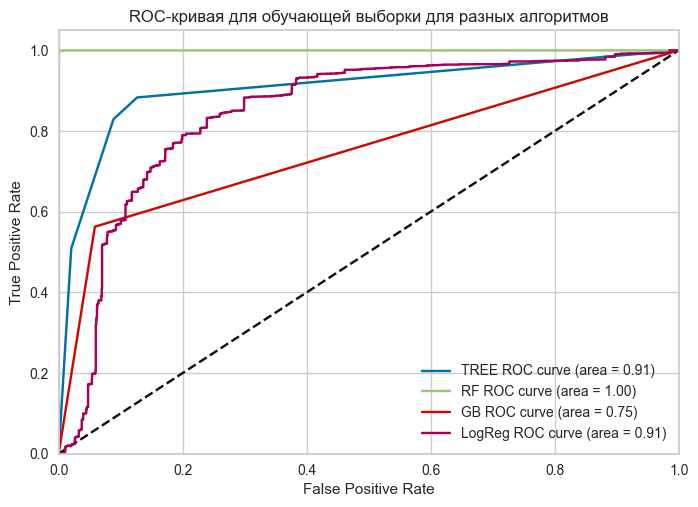

In [56]:
#Дерево
fpr_tree_train, tpr_tree_train, thresholds_tree_train = roc_curve(y_train,Y_tree_train_proba[:, 1])
roc_auc_tree_train = auc(fpr_tree_train, tpr_tree_train)
#Лес
fpr_rf_train, tpr_rf_train, thresholds_rf_train =roc_curve(y_train,Y_rf_train_proba[:, 1])
roc_auc_rf_train = auc(fpr_rf_train, tpr_rf_train)
#Бустинг
fpr_gb_train, tpr_gb_train, thresholds_gb_train =roc_curve(y_train,Y_gb_train_proba[:, 1])
roc_auc_gb_train = auc(fpr_gb_train, tpr_gb_train)
#Логистическая регрессия
fpr_logreg_train, tpr_logreg_train, thresholds_logreg_train =roc_curve(y_train,Y_logreg_train_proba[:, 1])
roc_auc_logreg_train = auc(fpr_tree_train, tpr_tree_train)


#Построим график
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для обучающей выборки для разных алгоритмов')

plt.plot(fpr_tree_train, tpr_tree_train, label='TREE ROC curve (area = %0.2f)' % roc_auc_tree_train)
plt.plot(fpr_rf_train, tpr_rf_train, label='RF ROC curve (area = %0.2f)' % roc_auc_rf_train)
plt.plot(fpr_gb_train, tpr_gb_train, label='GB ROC curve (area = %0.2f)' % roc_auc_gb_train)
plt.plot(fpr_logreg_train, tpr_logreg_train, label='LogReg ROC curve (area = %0.2f)' % roc_auc_logreg_train)
plt.legend(loc="lower right")

plt.show()

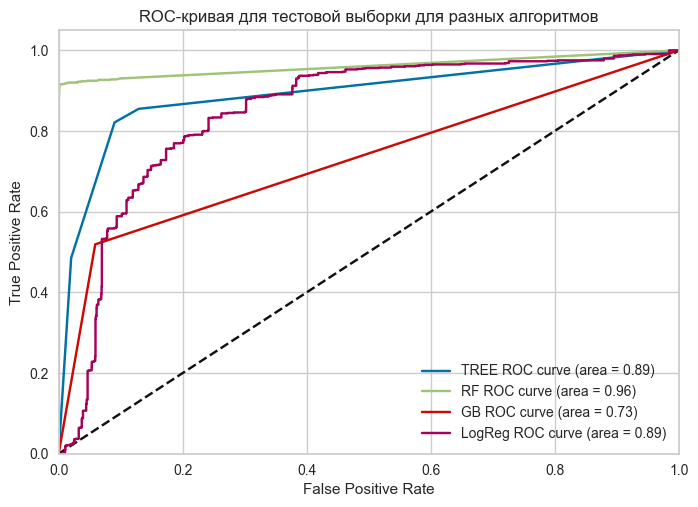

In [57]:
#Дерево
fpr_tree_tst, tpr_tree_tst, thresholds_tree_tst =roc_curve(y_test,Y_tree_tst_proba[:, 1])
roc_auc_tree_tst = auc(fpr_tree_tst, tpr_tree_tst)
#Лес
fpr_rf_tst, tpr_rf_tst, thresholds_rf_tst =roc_curve(y_test,Y_rf_tst_proba[:, 1])
roc_auc_rf_tst = auc(fpr_rf_tst, tpr_rf_tst)
#Бустинг
fpr_gb_tst, tpr_gb_tst, thresholds_gb_tst =roc_curve(y_test,Y_gb_tst_proba[:, 1])
roc_auc_gb_tst = auc(fpr_gb_tst, tpr_gb_tst)
#Логистическая регрессия
fpr_logreg_tst, tpr_logreg_tst, thresholds_logreg_tst =roc_curve(y_test,Y_logreg_tst_proba[:, 1])
roc_auc_logreg_tst = auc(fpr_tree_tst, tpr_tree_tst)


#Построим график
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для тестовой выборки для разных алгоритмов')

plt.plot(fpr_tree_tst, tpr_tree_tst, label='TREE ROC curve (area = %0.2f)' % roc_auc_tree_tst)
plt.plot(fpr_rf_tst, tpr_rf_tst, label='RF ROC curve (area = %0.2f)' % roc_auc_rf_tst)
plt.plot(fpr_gb_tst, tpr_gb_tst, label='GB ROC curve (area = %0.2f)' % roc_auc_gb_tst)
plt.plot(fpr_logreg_tst, tpr_logreg_tst, label='LogReg ROC curve (area = %0.2f)' % roc_auc_logreg_tst)
plt.legend(loc="lower right")

plt.show()

Дерево решений
ID переменной: 0, Score: 0.42354
ID переменной: 1, Score: 0.00000
ID переменной: 2, Score: 0.00000
ID переменной: 3, Score: 0.00000
ID переменной: 4, Score: 0.00000
ID переменной: 5, Score: 0.00000
ID переменной: 6, Score: 0.00000
ID переменной: 7, Score: 0.00000
ID переменной: 8, Score: 0.00000
ID переменной: 9, Score: 0.00000
ID переменной: 10, Score: 0.00000
ID переменной: 11, Score: 0.00000
ID переменной: 12, Score: 0.00000
ID переменной: 13, Score: 0.00000
ID переменной: 14, Score: 0.00000
ID переменной: 15, Score: 0.00000
ID переменной: 16, Score: 0.00000
ID переменной: 17, Score: 0.00000
ID переменной: 18, Score: 0.00000
ID переменной: 19, Score: 0.00000
ID переменной: 20, Score: 0.00000
ID переменной: 21, Score: 0.00000
ID переменной: 22, Score: 0.00000
ID переменной: 23, Score: 0.00000
ID переменной: 24, Score: 0.00000
ID переменной: 25, Score: 0.00000
ID переменной: 26, Score: 0.00000
ID переменной: 27, Score: 0.00000
ID переменной: 28, Score: 0.00000
ID переме

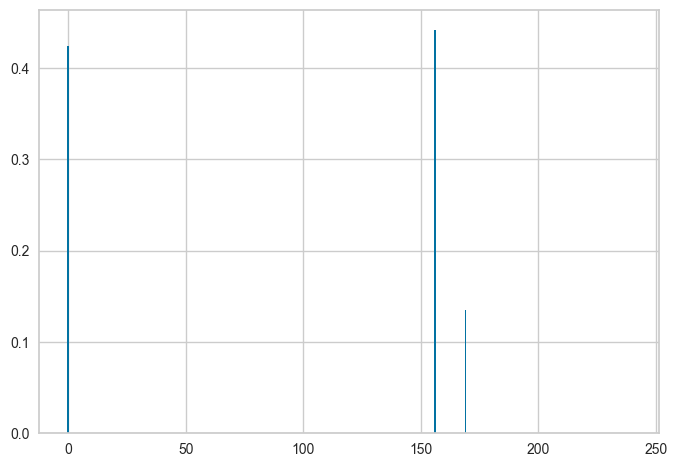

Случайный лес
ID переменной: 0, Score: 0.08103
ID переменной: 1, Score: 0.00000
ID переменной: 2, Score: 0.00000
ID переменной: 3, Score: 0.03950
ID переменной: 4, Score: 0.00000
ID переменной: 5, Score: 0.00000
ID переменной: 6, Score: 0.00019
ID переменной: 7, Score: 0.00221
ID переменной: 8, Score: 0.00197
ID переменной: 9, Score: 0.00045
ID переменной: 10, Score: 0.00118
ID переменной: 11, Score: 0.00452
ID переменной: 12, Score: 0.00003
ID переменной: 13, Score: 0.00019
ID переменной: 14, Score: 0.00260
ID переменной: 15, Score: 0.00017
ID переменной: 16, Score: 0.00098
ID переменной: 17, Score: 0.00009
ID переменной: 18, Score: 0.00419
ID переменной: 19, Score: 0.00001
ID переменной: 20, Score: 0.00134
ID переменной: 21, Score: 0.00420
ID переменной: 22, Score: 0.00006
ID переменной: 23, Score: 0.00009
ID переменной: 24, Score: 0.00001
ID переменной: 25, Score: 0.01447
ID переменной: 26, Score: 0.00003
ID переменной: 27, Score: 0.00712
ID переменной: 28, Score: 0.00012
ID перемен

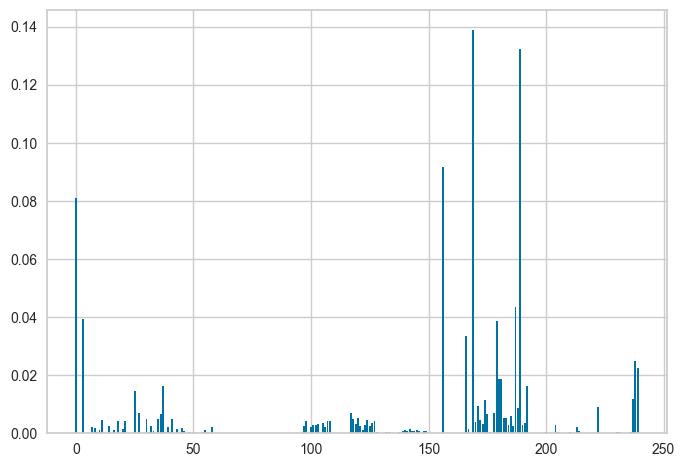

ID переменной: 0, Score: 1.00000
ID переменной: 1, Score: 0.00000
ID переменной: 2, Score: 0.00000
ID переменной: 3, Score: 0.00000
ID переменной: 4, Score: 0.00000
ID переменной: 5, Score: 0.00000
ID переменной: 6, Score: 0.00000
ID переменной: 7, Score: 0.00000
ID переменной: 8, Score: 0.00000
ID переменной: 9, Score: 0.00000
ID переменной: 10, Score: 0.00000
ID переменной: 11, Score: 0.00000
ID переменной: 12, Score: 0.00000
ID переменной: 13, Score: 0.00000
ID переменной: 14, Score: 0.00000
ID переменной: 15, Score: 0.00000
ID переменной: 16, Score: 0.00000
ID переменной: 17, Score: 0.00000
ID переменной: 18, Score: 0.00000
ID переменной: 19, Score: 0.00000
ID переменной: 20, Score: 0.00000
ID переменной: 21, Score: 0.00000
ID переменной: 22, Score: 0.00000
ID переменной: 23, Score: 0.00000
ID переменной: 24, Score: 0.00000
ID переменной: 25, Score: 0.00000
ID переменной: 26, Score: 0.00000
ID переменной: 27, Score: 0.00000
ID переменной: 28, Score: 0.00000
ID переменной: 29, Score

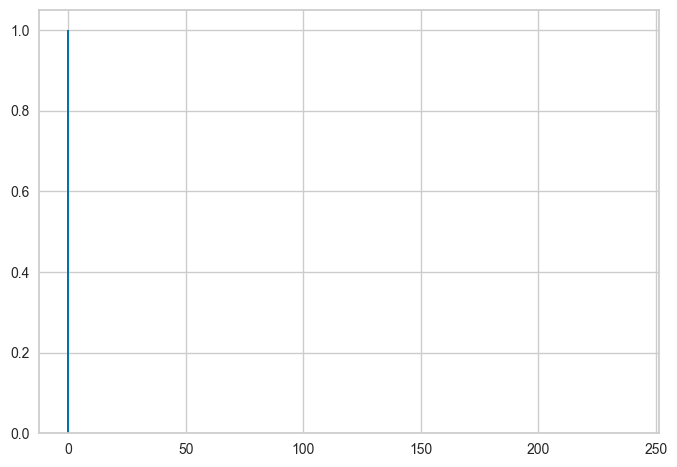

ID Переменной: 0, Score: 0.00000
ID Переменной: 1, Score: -0.00000
ID Переменной: 2, Score: 0.00000
ID Переменной: 3, Score: 0.00000
ID Переменной: 4, Score: -0.00000
ID Переменной: 5, Score: -0.00000
ID Переменной: 6, Score: -0.00000
ID Переменной: 7, Score: 0.00000
ID Переменной: 8, Score: -0.00000
ID Переменной: 9, Score: -0.00000
ID Переменной: 10, Score: -0.00000
ID Переменной: 11, Score: 0.00000
ID Переменной: 12, Score: -0.00000
ID Переменной: 13, Score: -0.00000
ID Переменной: 14, Score: 0.00000
ID Переменной: 15, Score: -0.00000
ID Переменной: 16, Score: -0.00000
ID Переменной: 17, Score: -0.00000
ID Переменной: 18, Score: 0.00000
ID Переменной: 19, Score: -0.00000
ID Переменной: 20, Score: -0.00000
ID Переменной: 21, Score: 0.00000
ID Переменной: 22, Score: -0.00000
ID Переменной: 23, Score: -0.00000
ID Переменной: 24, Score: -0.00000
ID Переменной: 25, Score: 0.00000
ID Переменной: 26, Score: -0.00000
ID Переменной: 27, Score: 0.00000
ID Переменной: 28, Score: -0.00000
ID Пе

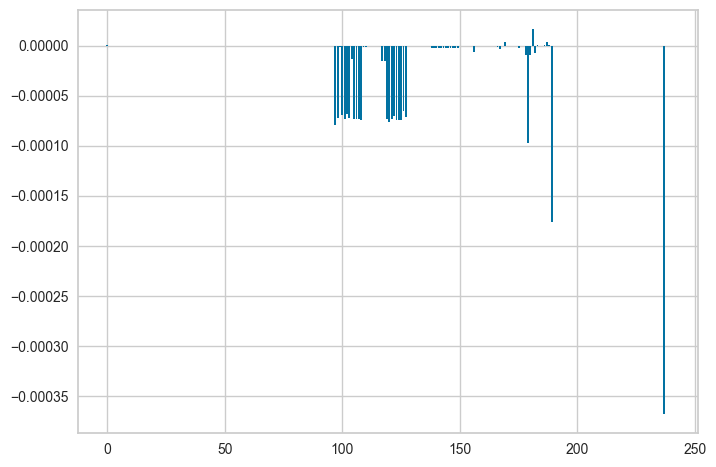

In [58]:
#Важность факторов

print('Дерево решений')

importance_tree = model_tree.feature_importances_
for i,v in enumerate(importance_tree): print('ID переменной: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_tree))], importance_tree)
plt.show()

print('Случайный лес')

importance_rf = model_rf.feature_importances_
for i,v in enumerate(importance_rf): print('ID переменной: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_rf))], importance_rf)
plt.show()

#Градиентный бустинг

importance_gb = model_gb.feature_importances_
for i,v in enumerate(importance_gb): print('ID переменной: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_gb))], importance_gb)
plt.show()


#Логистическая регрессия

#Важность факторов - коэффициенты регрессии
importance_logreg = model_logreg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance_logreg): print('ID Переменной: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_logreg))], importance_logreg)
plt.show()



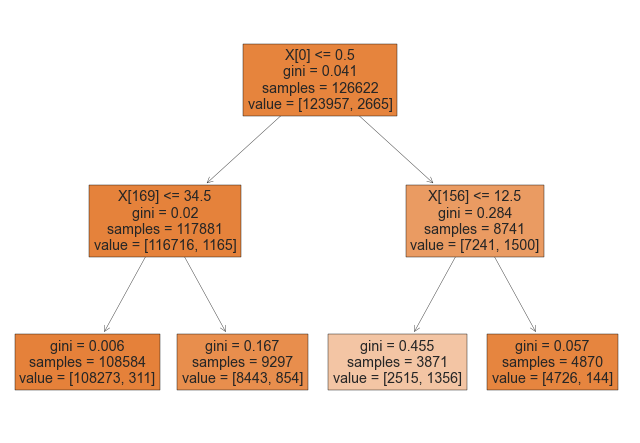

In [59]:
#Визуализация дерева
tree.plot_tree(model_tree, filled='True')
plt.show()

Macro avg и weighted avg отличаются в 2 раза,что не есть хорошо и говорит о большом дисбалансе классов. 

# Баланс на классификации

Имеем СИЛЬНО несбалансированые классы. Для того,чтобы не применять основыне методы борьбы с дисбалансом, поскольку они не всегда хорошо справляются со своей задачей,когда речь идёт о предугадывании точного дискретного значения, а не "ближе к этому,значит это". Здесь будет решаться совершенно другая задача: Мы построили модель находящую день поломки или не поломки. Теперь, мы построим модель, которая будет искать день поломки, основывваясь на результатах поломок по вине нашего целевого признака.

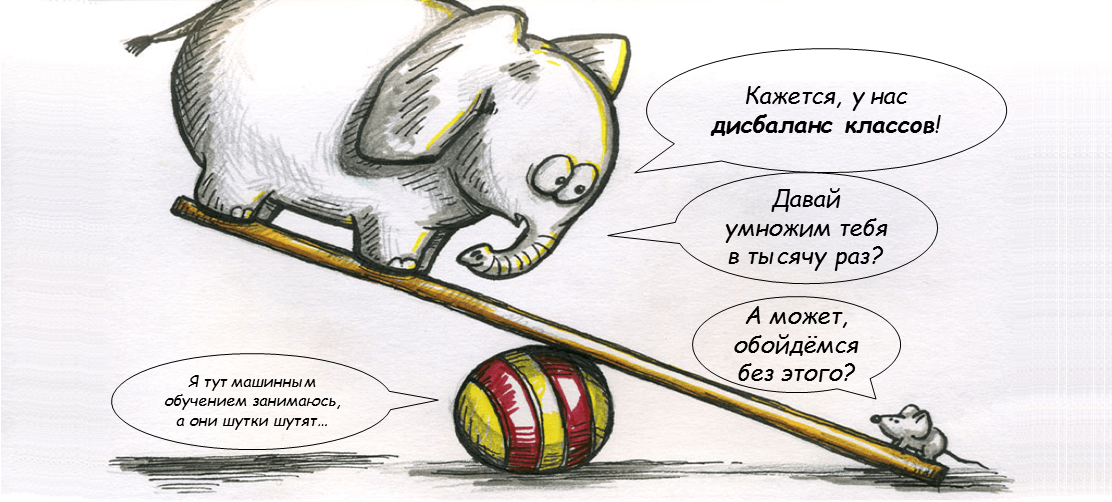

In [60]:
data_classify2

count_fail  107_repair_count  \
ser_loc zns_loc prs_loc year_month                                 
107     3.0     1.0     2020-01            1.0               0.0   
                        2019-03            1.0               0.0   
        4.0     1.0     2020-04            1.0               0.0   
                        2020-06            1.0               0.0   
                        2020-07            1.0               0.0   
...                                        ...               ...   
693     74.0    3.0     2019-03            0.0               0.0   
                        2021-04            0.0               0.0   
                        2021-05            0.0               0.0   
                        2021-07            0.0               0.0   
                        2021-10            0.0               0.0   

                                    307_repair_count  308_repair_count  \
ser_loc zns_loc prs_loc year_month                                       
107     3.0     1.0     2020-01                  0.0               0.0   
                        2019-03                  0.0               0.0   
        4.0     1.0     2020-04                  0.0               0.0   
                        2020-06                  0.0               0.0   
                        2020-07                  0.0               1.0   
...                                              ...               ...   
693     74.0    3.0     2019-03                  0.0               0.0   
                        2021-04                  0.0               0.0   
                        2021-05                  0.0               0.0   
                        2021-07                  0.0               0.0   
                        2021-10                  0.0               0.0   

                                    309_repair_count  521_repair_count  \
ser_loc zns_loc prs_loc year_month                                       
107     3.0     1.0     2020-01                  0.0               0.0   
                        2019-03                  0.0               0.0   
        4.0     1.0     2020-04                  0.0               0.0   
                        2020-06                  0.0               0.0   
                        2020-07                  0.0               0.0   
...                                              ...               ...   
693     74.0    3.0     2019-03                  0.0               0.0   
                        2021-04                  0.0               0.0   
                        2021-05                  0.0               0.0   
                        2021-07                  0.0               0.0   
                        2021-10                  0.0               0.0   

                                    800_repair_count  801_repair_count  \
ser_loc zns_loc prs_loc year_month                                       
107     3.0     1.0     2020-01                  0.0               0.0   
                        2019-03                  0.0               0.0   
        4.0     1.0     2020-04                  0.0               1.0   
                        2020-06                  0.0               1.0   
                        2020-07                  0.0               0.0   
...                                              ...               ...   
693     74.0    3.0     2019-03                  0.0               0.0   
                        2021-04                  0.0               0.0   
                        2021-05                  0.0               0.0   
                        2021-07                  0.0               0.0   
                        2021-10                  0.0               0.0   

                                    автоматический перевод в нр при превышении норм на то-2  \
ser_loc zns_loc prs_loc year_month                                                            
107     3.0     1.0     2020-01                                         

Для баланса классов используем Способ Передискретизации синтезированных меньшинств - SMOTE

In [61]:
X =data_classify2.drop(columns="day")
Y=data_classify2["day"]
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=1)

In [62]:

smote = SMOTE(random_state=1000)
x_, y_ = smote.fit_resample(X, Y)
print(x_[y_==0].shape)
print(x_[y_==1].shape)

(165275, 240)
(165275, 240)


In [63]:
X_train, X_test, y_train, y_test = train_test_split(x_,y_,random_state=1)

In [64]:


#Дерево решений
model_tree = tree.DecisionTreeClassifier(criterion='gini', random_state=42,max_depth=2).fit(X_train,np.ravel(y_train))

#Случайный лес
model_rf = RandomForestClassifier(n_estimators=10, 
                                  random_state=42, max_depth=40, bootstrap='false').fit(X_train, np.ravel(y_train))


#Градиентный бустинг
model_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                      max_depth=1, random_state=42).fit(X_train, np.ravel(y_train))

#Логистическая регрессия
model_logreg = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, np.ravel(y_train))
model_tree


DecisionTreeClassifier(max_depth=2, random_state=42)

In [65]:
#Оценим получившиеся классификаторы

#Применим модель, чтобы посчитать модельные результаты
#Обучающая выборка
Y_tree_train=model_tree.predict(X_train)
Y_rf_train=model_rf.predict(X_train)
Y_gb_train=model_gb.predict(X_train)
Y_logreg_train=model_logreg.predict(X_train)
#вероятности
Y_tree_train_proba=model_tree.predict_proba(X_train)
Y_rf_train_proba=model_rf.predict_proba(X_train)
Y_gb_train_proba=model_gb.predict_proba(X_train)
Y_logreg_train_proba=model_logreg.predict_proba(X_train)


#Тестовая выборка
Y_tree_tst=model_tree.predict(X_test)
Y_rf_tst=model_rf.predict(X_test)
Y_gb_tst=model_gb.predict(X_test)
Y_logreg_tst=model_logreg.predict(X_test)

#вероятности
Y_tree_tst_proba=model_tree.predict_proba(X_test)
Y_rf_tst_proba=model_rf.predict_proba(X_test)
Y_gb_tst_proba=model_gb.predict_proba(X_test)
Y_logreg_tst_proba=model_logreg.predict_proba(X_test)

Confusion Matrix Дерево решений


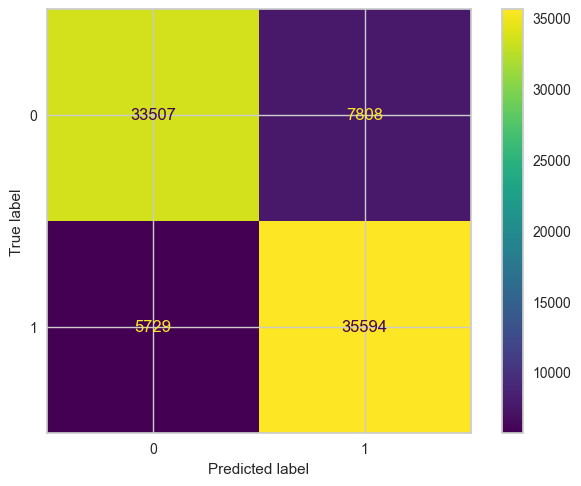

Confusion Matrix Случайный лес


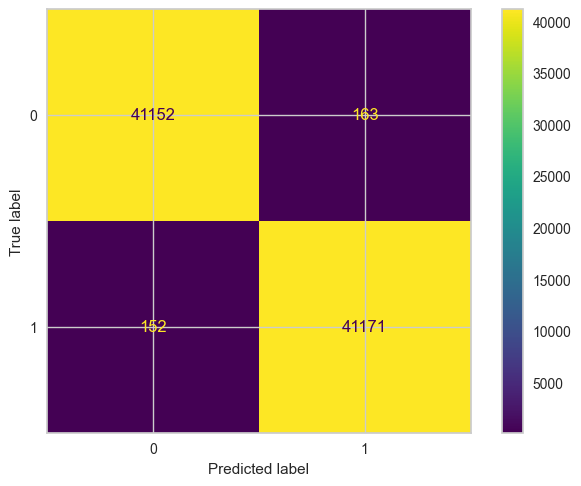

Confusion Matrix Градиентный бустинг


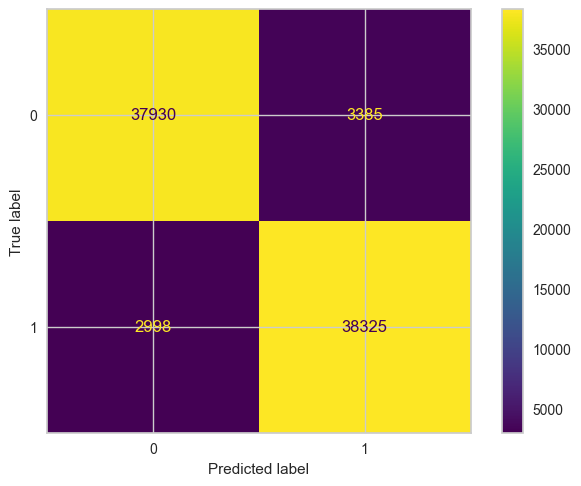

Confusion Matrix Логистическая регрессия


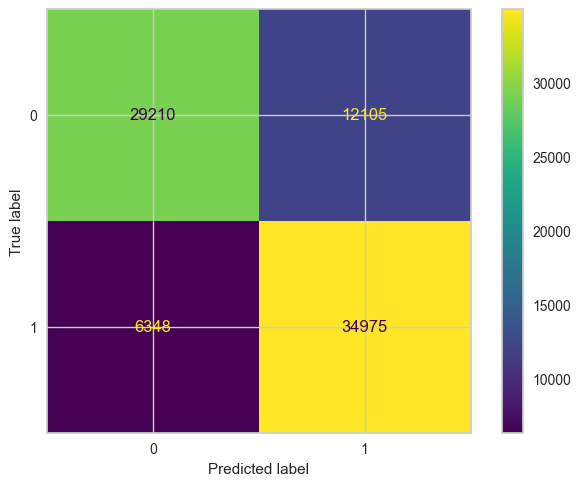

In [66]:
#Перед тем, как считать метрики посмотрим на Confusion Matrix

#Дерево
print('Confusion Matrix Дерево решений')
cm_tree = confusion_matrix(y_test, Y_tree_tst, labels=model_tree.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=model_tree.classes_)
disp_tree.plot()
plt.show()

#Случайный лес
print('Confusion Matrix Случайный лес')
cm_rf = confusion_matrix(y_test, Y_rf_tst, labels=model_rf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=model_rf.classes_)
disp_rf.plot()
plt.show()

#Градиентный бустинг
print('Confusion Matrix Градиентный бустинг')
cm_gb = confusion_matrix(y_test, Y_gb_tst, labels=model_gb.classes_)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=model_gb.classes_)
disp_gb.plot()
plt.show()

#Логистическая регрессия
print('Confusion Matrix Логистическая регрессия')
cm_logreg = confusion_matrix(y_test, Y_logreg_tst, labels=model_logreg.classes_)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=model_logreg.classes_)
disp_logreg.plot()
plt.show()

In [67]:


TREE_CLR=classification_report(y_test,Y_tree_tst)
print("Метрики Деревья решений на тестовой выборке")
print(TREE_CLR)

RF_CLR=classification_report(y_test,Y_rf_tst)
print("Метрики Случайный лес на тестовой выборке")
print(RF_CLR)

GB_CLR=classification_report(y_test,Y_gb_tst)
print("Метрики Градиентный бустинг на тестовой выборке")
print(GB_CLR)

LOGREG_CLR=classification_report(y_test,Y_gb_tst)
print("Метрики Логистическая регрессия на тестовой выборке")
print(LOGREG_CLR)

Метрики Деревья решений на тестовой выборке
              precision    recall  f1-score   support

           0       0.85      0.81      0.83     41315
           1       0.82      0.86      0.84     41323

    accuracy                           0.84     82638
   macro avg       0.84      0.84      0.84     82638
weighted avg       0.84      0.84      0.84     82638

Метрики Случайный лес на тестовой выборке
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41315
           1       1.00      1.00      1.00     41323

    accuracy                           1.00     82638
   macro avg       1.00      1.00      1.00     82638
weighted avg       1.00      1.00      1.00     82638

Метрики Градиентный бустинг на тестовой выборке
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     41315
           1       0.92      0.93      0.92     41323

    accuracy                           0.92     

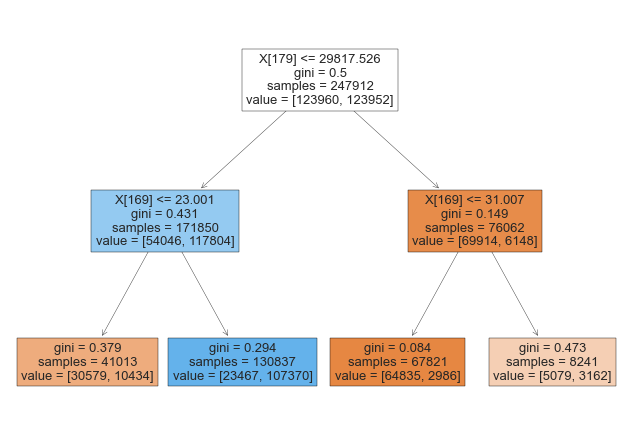

In [68]:
#Визуализация дерева
tree.plot_tree(model_tree, filled='True')
plt.show()

МЫ построили древо и узнали признаки, которые определяют нашу классификацию

# Catboostclassifier

In [69]:
clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    loss_function='CrossEntropy'
)

In [70]:
clf.fit(X_train, y_train,         
        eval_set=(X_test, y_test), 
        verbose=False
)

# Точность на обучающей и тестовой выборке (средняя)

In [71]:
val_score = clf.score(X_test, y_test) # val (test) score
train_score = clf.score(X_train, y_train) # train (learn) score

val_score,train_score

(0.9222633655219149, 0.9225249282003292)

In [72]:
cat_pr = clf.predict(X_test)

# Иная модель оценки

Будем брать процент предугаданных значений за оценку,и сравним её с более известными и принятыми в машинном обучении оценками.

# Проверим catboost classifier

In [73]:
d = {'day':y_test}
Predict_test = pd.DataFrame(data=d)
Predict_test['predict'] = cat_pr
print('Верно спрогнозированное событие, %: ', len(Predict_test[(Predict_test['predict'] == 1)&(Predict_test['day'] == 1)].index)/len(Predict_test[Predict_test['day'] == 1].index))
print('Верно спрогнозированное отсуствие события, %: ', len(Predict_test[(Predict_test['predict'] == 0)&(Predict_test['day'] == 0)].index)/len(Predict_test[Predict_test['day'] == 0].index))

Верно спрогнозированное событие, %:  0.9041453911865063
Верно спрогнозированное отсуствие события, %:  0.940384848118117


Наша оценка очень близка к оценке score/которая показывет метрику точности.

# Классификация ч.2

Теперь будет строить модель классификации только по нашим поломкам.1 - отказ в первой половине, 0 -во второй

In [74]:
data_classify2 = data_new.copy()
data_classify2 = data_classify2.dropna()
data_classify2['day'] = [0 if x > 15 else 1 for x in data_classify2['day']]
data_classify2 = data_classify2.set_index(['ser_loc','zns_loc','prs_loc','year_month'])

In [75]:
data_classify2['day'].value_counts()

0    2462
1    1093
Name: day, dtype: int64

In [76]:

X =data_classify2.drop(columns="day")
Y=data_classify2["day"]
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=1)

In [77]:

#Дерево решений
model_tree = tree.DecisionTreeClassifier(criterion='gini', random_state=42,max_depth=2).fit(X_train,np.ravel(y_train))

#Случайный лес
model_rf = RandomForestClassifier(n_estimators=10, 
                                  random_state=42, max_depth=40, bootstrap='false').fit(X_train, np.ravel(y_train))


#Градиентный бустинг
model_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                      max_depth=1, random_state=42).fit(X_train, np.ravel(y_train))

#Логистическая регрессия
model_logreg = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, np.ravel(y_train))
model_tree


DecisionTreeClassifier(max_depth=2, random_state=42)

In [78]:
#Оценим получившиеся классификаторы

#Применим модель, чтобы посчитать модельные результаты
#Обучающая выборка
Y_tree_train=model_tree.predict(X_train)
Y_rf_train=model_rf.predict(X_train)
Y_gb_train=model_gb.predict(X_train)
Y_logreg_train=model_logreg.predict(X_train)
#вероятности
Y_tree_train_proba=model_tree.predict_proba(X_train)
Y_rf_train_proba=model_rf.predict_proba(X_train)
Y_gb_train_proba=model_gb.predict_proba(X_train)
Y_logreg_train_proba=model_logreg.predict_proba(X_train)


#Тестовая выборка
Y_tree_tst=model_tree.predict(X_test)
Y_rf_tst=model_rf.predict(X_test)
Y_gb_tst=model_gb.predict(X_test)
Y_logreg_tst=model_logreg.predict(X_test)

#вероятности
Y_tree_tst_proba=model_tree.predict_proba(X_test)
Y_rf_tst_proba=model_rf.predict_proba(X_test)
Y_gb_tst_proba=model_gb.predict_proba(X_test)
Y_logreg_tst_proba=model_logreg.predict_proba(X_test)

Confusion Matrix Дерево решений


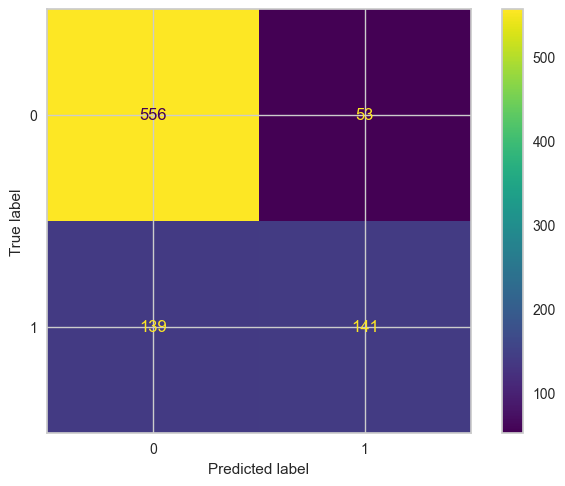

Confusion Matrix Случайный лес


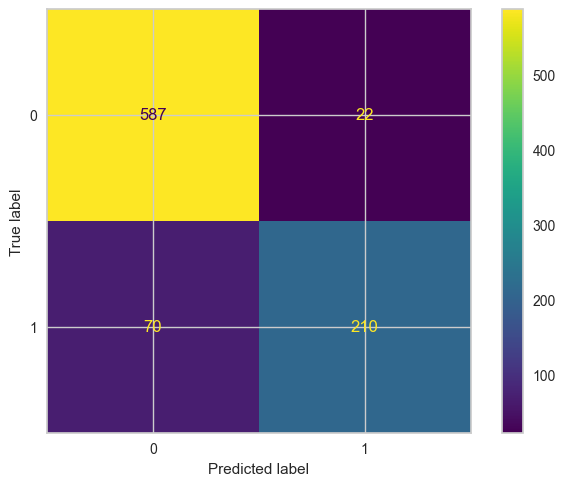

Confusion Matrix Градиентный бустинг


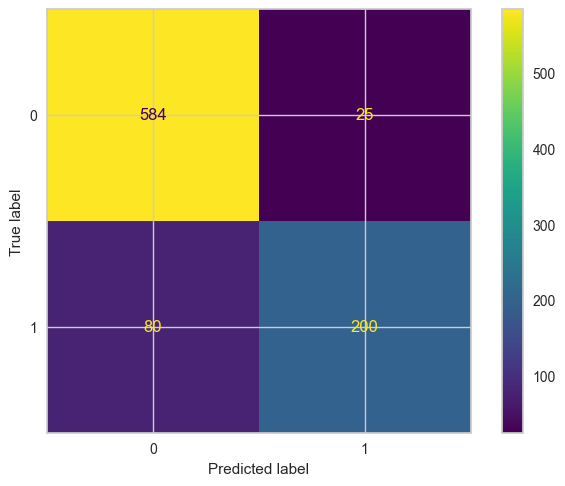

Confusion Matrix Логистическая регрессия


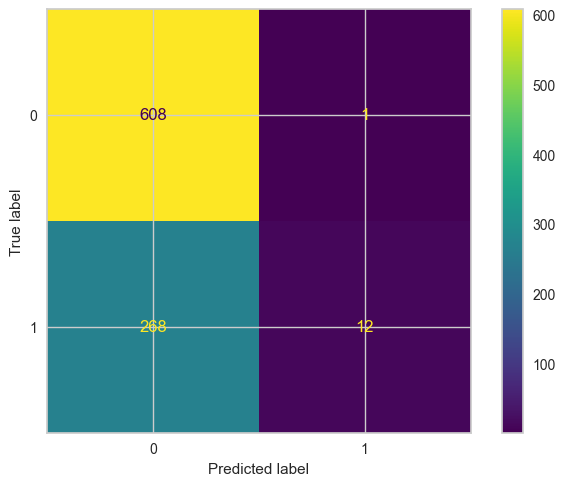

In [79]:
#Перед тем, как считать метрики посмотрим на Confusion Matrix

#Дерево
print('Confusion Matrix Дерево решений')
cm_tree = confusion_matrix(y_test, Y_tree_tst, labels=model_tree.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=model_tree.classes_)
disp_tree.plot()
plt.show()

#Случайный лес
print('Confusion Matrix Случайный лес')
cm_rf = confusion_matrix(y_test, Y_rf_tst, labels=model_rf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=model_rf.classes_)
disp_rf.plot()
plt.show()

#Градиентный бустинг
print('Confusion Matrix Градиентный бустинг')
cm_gb = confusion_matrix(y_test, Y_gb_tst, labels=model_gb.classes_)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=model_gb.classes_)
disp_gb.plot()
plt.show()

#Логистическая регрессия
print('Confusion Matrix Логистическая регрессия')
cm_logreg = confusion_matrix(y_test, Y_logreg_tst, labels=model_logreg.classes_)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=model_logreg.classes_)
disp_logreg.plot()
plt.show()

In [80]:


TREE_CLR=classification_report(y_test,Y_tree_tst)
print("Метрики Деревья решений на тестовой выборке")
print(TREE_CLR)

RF_CLR=classification_report(y_test,Y_rf_tst)
print("Метрики Случайный лес на тестовой выборке")
print(RF_CLR)

GB_CLR=classification_report(y_test,Y_gb_tst)
print("Метрики Градиентный бустинг на тестовой выборке")
print(GB_CLR)

LOGREG_CLR=classification_report(y_test,Y_gb_tst)
print("Метрики Логистическая регрессия на тестовой выборке")
print(LOGREG_CLR)

Метрики Деревья решений на тестовой выборке
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       609
           1       0.73      0.50      0.59       280

    accuracy                           0.78       889
   macro avg       0.76      0.71      0.72       889
weighted avg       0.78      0.78      0.77       889

Метрики Случайный лес на тестовой выборке
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       609
           1       0.91      0.75      0.82       280

    accuracy                           0.90       889
   macro avg       0.90      0.86      0.87       889
weighted avg       0.90      0.90      0.89       889

Метрики Градиентный бустинг на тестовой выборке
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       609
           1       0.89      0.71      0.79       280

    accuracy                           0.88     

# Проверка с нашими критериями

In [81]:
d = {'day':y_test}
Predict_test = pd.DataFrame(data=d)
Predict_test['predict'] = Y_rf_tst
print('Верно спрогнозированное событие, %: ', len(Predict_test[(Predict_test['predict'] == 1)&(Predict_test['day'] == 1)].index)/len(Predict_test[Predict_test['day'] == 1].index))
print('Верно спрогнозированное отсуствие события, %: ', len(Predict_test[(Predict_test['predict'] == 0)&(Predict_test['day'] == 0)].index)/len(Predict_test[Predict_test['day'] == 0].index))

Верно спрогнозированное событие, %:  0.75
Верно спрогнозированное отсуствие события, %:  0.9638752052545156


In [82]:
d = {'day':y_test}
Predict_test = pd.DataFrame(data=d)
Predict_test['predict'] = Y_gb_tst
print('Верно спрогнозированное событие, %: ', len(Predict_test[(Predict_test['predict'] == 1)&(Predict_test['day'] == 1)].index)/len(Predict_test[Predict_test['day'] == 1].index))
print('Верно спрогнозированное отсуствие события, %: ', len(Predict_test[(Predict_test['predict'] == 0)&(Predict_test['day'] == 0)].index)/len(Predict_test[Predict_test['day'] == 0].index))

Верно спрогнозированное событие, %:  0.7142857142857143
Верно спрогнозированное отсуствие события, %:  0.9589490968801314


Первый критерий близок к macro avg.precision, а второй к f1-score accuracy

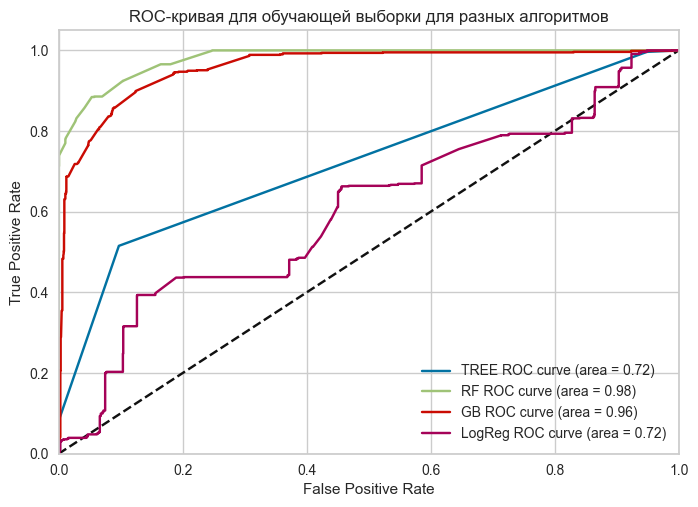

In [83]:
#Дерево
fpr_tree_train, tpr_tree_train, thresholds_tree_train = roc_curve(y_train,Y_tree_train_proba[:, 1])
roc_auc_tree_train = auc(fpr_tree_train, tpr_tree_train)
#Лес
fpr_rf_train, tpr_rf_train, thresholds_rf_train =roc_curve(y_train,Y_rf_train_proba[:, 1])
roc_auc_rf_train = auc(fpr_rf_train, tpr_rf_train)
#Бустинг
fpr_gb_train, tpr_gb_train, thresholds_gb_train =roc_curve(y_train,Y_gb_train_proba[:, 1])
roc_auc_gb_train = auc(fpr_gb_train, tpr_gb_train)
#Логистическая регрессия
fpr_logreg_train, tpr_logreg_train, thresholds_logreg_train =roc_curve(y_train,Y_logreg_train_proba[:, 1])
roc_auc_logreg_train = auc(fpr_tree_train, tpr_tree_train)


#Построим график
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для обучающей выборки для разных алгоритмов')

plt.plot(fpr_tree_train, tpr_tree_train, label='TREE ROC curve (area = %0.2f)' % roc_auc_tree_train)
plt.plot(fpr_rf_train, tpr_rf_train, label='RF ROC curve (area = %0.2f)' % roc_auc_rf_train)
plt.plot(fpr_gb_train, tpr_gb_train, label='GB ROC curve (area = %0.2f)' % roc_auc_gb_train)
plt.plot(fpr_logreg_train, tpr_logreg_train, label='LogReg ROC curve (area = %0.2f)' % roc_auc_logreg_train)
plt.legend(loc="lower right")

plt.show()

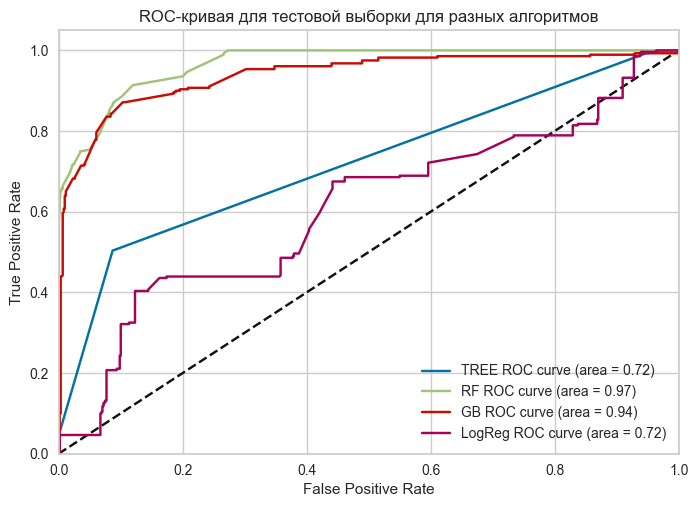

In [84]:
#Дерево
fpr_tree_tst, tpr_tree_tst, thresholds_tree_tst =roc_curve(y_test,Y_tree_tst_proba[:, 1])
roc_auc_tree_tst = auc(fpr_tree_tst, tpr_tree_tst)
#Лес
fpr_rf_tst, tpr_rf_tst, thresholds_rf_tst =roc_curve(y_test,Y_rf_tst_proba[:, 1])
roc_auc_rf_tst = auc(fpr_rf_tst, tpr_rf_tst)
#Бустинг
fpr_gb_tst, tpr_gb_tst, thresholds_gb_tst =roc_curve(y_test,Y_gb_tst_proba[:, 1])
roc_auc_gb_tst = auc(fpr_gb_tst, tpr_gb_tst)
#Логистическая регрессия
fpr_logreg_tst, tpr_logreg_tst, thresholds_logreg_tst =roc_curve(y_test,Y_logreg_tst_proba[:, 1])
roc_auc_logreg_tst = auc(fpr_tree_tst, tpr_tree_tst)


#Построим график
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для тестовой выборки для разных алгоритмов')

plt.plot(fpr_tree_tst, tpr_tree_tst, label='TREE ROC curve (area = %0.2f)' % roc_auc_tree_tst)
plt.plot(fpr_rf_tst, tpr_rf_tst, label='RF ROC curve (area = %0.2f)' % roc_auc_rf_tst)
plt.plot(fpr_gb_tst, tpr_gb_tst, label='GB ROC curve (area = %0.2f)' % roc_auc_gb_tst)
plt.plot(fpr_logreg_tst, tpr_logreg_tst, label='LogReg ROC curve (area = %0.2f)' % roc_auc_logreg_tst)
plt.legend(loc="lower right")

plt.show()

Дерево решений
ID переменной: 0, Score: 0.00000
ID переменной: 1, Score: 0.00000
ID переменной: 2, Score: 0.00000
ID переменной: 3, Score: 0.00000
ID переменной: 4, Score: 0.00000
ID переменной: 5, Score: 0.00000
ID переменной: 6, Score: 0.00000
ID переменной: 7, Score: 0.00000
ID переменной: 8, Score: 0.00000
ID переменной: 9, Score: 0.00000
ID переменной: 10, Score: 0.00000
ID переменной: 11, Score: 0.00000
ID переменной: 12, Score: 0.00000
ID переменной: 13, Score: 0.00000
ID переменной: 14, Score: 0.00000
ID переменной: 15, Score: 0.00000
ID переменной: 16, Score: 0.00000
ID переменной: 17, Score: 0.00000
ID переменной: 18, Score: 0.00000
ID переменной: 19, Score: 0.00000
ID переменной: 20, Score: 0.00000
ID переменной: 21, Score: 0.00000
ID переменной: 22, Score: 0.00000
ID переменной: 23, Score: 0.00000
ID переменной: 24, Score: 0.00000
ID переменной: 25, Score: 0.00000
ID переменной: 26, Score: 0.00000
ID переменной: 27, Score: 0.00000
ID переменной: 28, Score: 0.00000
ID переме

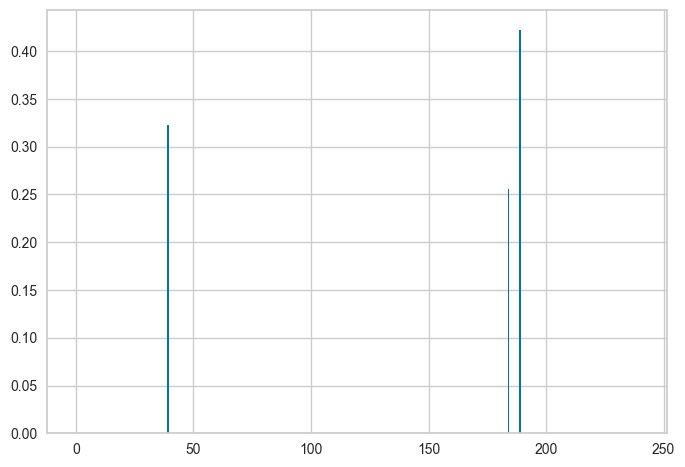

Случайный лес
ID переменной: 0, Score: 0.03726
ID переменной: 1, Score: 0.00000
ID переменной: 2, Score: 0.00000
ID переменной: 3, Score: 0.04154
ID переменной: 4, Score: 0.00000
ID переменной: 5, Score: 0.00000
ID переменной: 6, Score: 0.00000
ID переменной: 7, Score: 0.00535
ID переменной: 8, Score: 0.00106
ID переменной: 9, Score: 0.00033
ID переменной: 10, Score: 0.00059
ID переменной: 11, Score: 0.01146
ID переменной: 12, Score: 0.00022
ID переменной: 13, Score: 0.00000
ID переменной: 14, Score: 0.00512
ID переменной: 15, Score: 0.00162
ID переменной: 16, Score: 0.00020
ID переменной: 17, Score: 0.00000
ID переменной: 18, Score: 0.00003
ID переменной: 19, Score: 0.00000
ID переменной: 20, Score: 0.00030
ID переменной: 21, Score: 0.00488
ID переменной: 22, Score: 0.00000
ID переменной: 23, Score: 0.00000
ID переменной: 24, Score: 0.00000
ID переменной: 25, Score: 0.00454
ID переменной: 26, Score: 0.00000
ID переменной: 27, Score: 0.00322
ID переменной: 28, Score: 0.00000
ID перемен

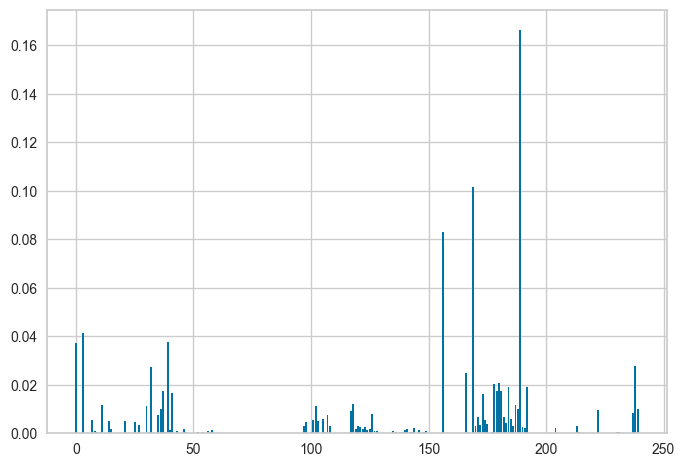

ID переменной: 0, Score: 0.02529
ID переменной: 1, Score: 0.00000
ID переменной: 2, Score: 0.00000
ID переменной: 3, Score: 0.05151
ID переменной: 4, Score: 0.00000
ID переменной: 5, Score: 0.00000
ID переменной: 6, Score: 0.00000
ID переменной: 7, Score: 0.00000
ID переменной: 8, Score: 0.00000
ID переменной: 9, Score: 0.00000
ID переменной: 10, Score: 0.00000
ID переменной: 11, Score: 0.00465
ID переменной: 12, Score: 0.00000
ID переменной: 13, Score: 0.00000
ID переменной: 14, Score: 0.00131
ID переменной: 15, Score: 0.00800
ID переменной: 16, Score: 0.00000
ID переменной: 17, Score: 0.00000
ID переменной: 18, Score: 0.00000
ID переменной: 19, Score: 0.00000
ID переменной: 20, Score: 0.00125
ID переменной: 21, Score: 0.00000
ID переменной: 22, Score: 0.00000
ID переменной: 23, Score: 0.00000
ID переменной: 24, Score: 0.00000
ID переменной: 25, Score: 0.00000
ID переменной: 26, Score: 0.00000
ID переменной: 27, Score: 0.00000
ID переменной: 28, Score: 0.00000
ID переменной: 29, Score

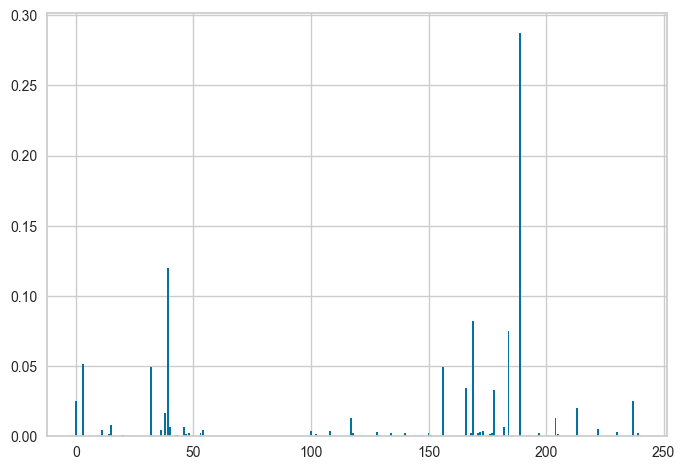

ID Переменной: 0, Score: -0.00000
ID Переменной: 1, Score: 0.00000
ID Переменной: 2, Score: 0.00000
ID Переменной: 3, Score: -0.00000
ID Переменной: 4, Score: 0.00000
ID Переменной: 5, Score: 0.00000
ID Переменной: 6, Score: 0.00000
ID Переменной: 7, Score: -0.00000
ID Переменной: 8, Score: 0.00000
ID Переменной: 9, Score: 0.00000
ID Переменной: 10, Score: -0.00000
ID Переменной: 11, Score: -0.00000
ID Переменной: 12, Score: 0.00000
ID Переменной: 13, Score: 0.00000
ID Переменной: 14, Score: -0.00000
ID Переменной: 15, Score: 0.00000
ID Переменной: 16, Score: -0.00000
ID Переменной: 17, Score: 0.00000
ID Переменной: 18, Score: -0.00000
ID Переменной: 19, Score: 0.00000
ID Переменной: 20, Score: 0.00000
ID Переменной: 21, Score: -0.00000
ID Переменной: 22, Score: 0.00000
ID Переменной: 23, Score: 0.00000
ID Переменной: 24, Score: 0.00000
ID Переменной: 25, Score: -0.00000
ID Переменной: 26, Score: 0.00000
ID Переменной: 27, Score: -0.00000
ID Переменной: 28, Score: 0.00000
ID Переменной

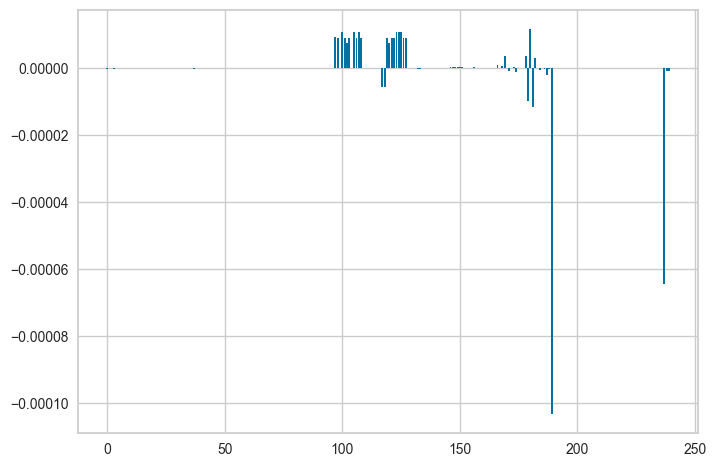

In [85]:
#Важность факторов

print('Дерево решений')

importance_tree = model_tree.feature_importances_
for i,v in enumerate(importance_tree): print('ID переменной: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_tree))], importance_tree)
plt.show()

print('Случайный лес')

importance_rf = model_rf.feature_importances_
for i,v in enumerate(importance_rf): print('ID переменной: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_rf))], importance_rf)
plt.show()

#Градиентный бустинг

importance_gb = model_gb.feature_importances_
for i,v in enumerate(importance_gb): print('ID переменной: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_gb))], importance_gb)
plt.show()


#Логистическая регрессия

#Важность факторов - коэффициенты регрессии
importance_logreg = model_logreg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance_logreg): print('ID Переменной: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance_logreg))], importance_logreg)
plt.show()



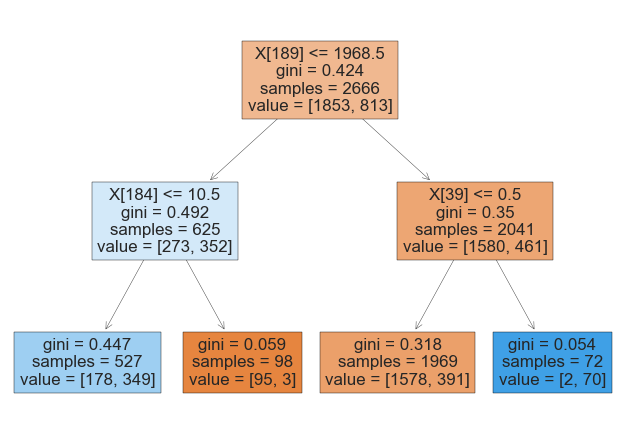

In [86]:
#Визуализация дерева
tree.plot_tree(model_tree, filled='True')
plt.show()

Macro avg и weighted avg отличаются в 2 раза,что не есть хорошо и говорит о большом дисбалансе классов. 

# Баланс на классификации

In [87]:
data_classify2

count_fail  107_repair_count  \
ser_loc zns_loc prs_loc year_month                                 
123     302.0   1.0     2020-12            1.0               0.0   
                        2020-12            1.0               0.0   
                        2020-12            1.0               0.0   
                        2020-12            1.0               0.0   
                        2020-12            1.0               0.0   
...                                        ...               ...   
640     104.0   2.0     2020-11            0.0               0.0   
        106.0   1.0     2020-10            0.0               0.0   
        119.0   2.0     2020-07            0.0               0.0   
        151.0   2.0     2020-07            0.0               0.0   
        266.0   2.0     2019-03            0.0               0.0   

                                    307_repair_count  308_repair_count  \
ser_loc zns_loc prs_loc year_month                                       
123     302.0   1.0     2020-12                  0.0               0.0   
                        2020-12                  0.0               0.0   
                        2020-12                  0.0               0.0   
                        2020-12                  0.0               0.0   
                        2020-12                  0.0               0.0   
...                                              ...               ...   
640     104.0   2.0     2020-11                  0.0               0.0   
        106.0   1.0     2020-10                  0.0               0.0   
        119.0   2.0     2020-07                  0.0               0.0   
        151.0   2.0     2020-07                  0.0               0.0   
        266.0   2.0     2019-03                  0.0               0.0   

                                    309_repair_count  521_repair_count  \
ser_loc zns_loc prs_loc year_month                                       
123     302.0   1.0     2020-12                  0.0               0.0   
                        2020-12                  0.0               0.0   
                        2020-12                  0.0               0.0   
                        2020-12                  0.0               0.0   
                        2020-12                  0.0               0.0   
...                                              ...               ...   
640     104.0   2.0     2020-11                  0.0               0.0   
        106.0   1.0     2020-10                  0.0               0.0   
        119.0   2.0     2020-07                  0.0               0.0   
        151.0   2.0     2020-07                  0.0               0.0   
        266.0   2.0     2019-03                  0.0               0.0   

                                    800_repair_count  801_repair_count  \
ser_loc zns_loc prs_loc year_month                                       
123     302.0   1.0     2020-12                  0.0               0.0   
                        2020-12                  0.0               0.0   
                        2020-12                  0.0               0.0   
                        2020-12                  0.0               0.0   
                        2020-12                  0.0               0.0   
...                                              ...               ...   
640     104.0   2.0     2020-11                  0.0               0.0   
        106.0   1.0     2020-10                  0.0               0.0   
        119.0   2.0     2020-07                  0.0               0.0   
        151.0   2.0     2020-07                  0.0               0.0   
        266.0   2.0     2019-03                  0.0               0.0   

                                    автоматический перевод в нр при превышении норм на то-2  \
ser_loc zns_loc prs_loc year_month                                                            
123     302.0   1.0     2020-12                                         

Для баланса классов используем Способ Передискретизации синтезированных меньшинств - SMOTE

In [88]:
X =data_classify2.drop(columns="day")
Y=data_classify2["day"]
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=1)

In [89]:

smote = SMOTE(random_state=1000)
x_, y_ = smote.fit_resample(X, Y)
print(x_[y_==0].shape)
print(x_[y_==1].shape)

(2462, 240)
(2462, 240)


In [90]:
X_train, X_test, y_train, y_test = train_test_split(x_,y_,random_state=1)

In [91]:


#Дерево решений
model_tree = tree.DecisionTreeClassifier(criterion='gini', random_state=42,max_depth=2).fit(X_train,np.ravel(y_train))

#Случайный лес
model_rf = RandomForestClassifier(n_estimators=10, 
                                  random_state=42, max_depth=40, bootstrap='false').fit(X_train, np.ravel(y_train))


#Градиентный бустинг
model_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                      max_depth=1, random_state=42).fit(X_train, np.ravel(y_train))

#Логистическая регрессия
model_logreg = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, np.ravel(y_train))
model_tree


DecisionTreeClassifier(max_depth=2, random_state=42)

In [92]:
#Оценим получившиеся классификаторы

#Применим модель, чтобы посчитать модельные результаты
#Обучающая выборка
Y_tree_train=model_tree.predict(X_train)
Y_rf_train=model_rf.predict(X_train)
Y_gb_train=model_gb.predict(X_train)
Y_logreg_train=model_logreg.predict(X_train)
#вероятности
Y_tree_train_proba=model_tree.predict_proba(X_train)
Y_rf_train_proba=model_rf.predict_proba(X_train)
Y_gb_train_proba=model_gb.predict_proba(X_train)
Y_logreg_train_proba=model_logreg.predict_proba(X_train)


#Тестовая выборка
Y_tree_tst=model_tree.predict(X_test)
Y_rf_tst=model_rf.predict(X_test)
Y_gb_tst=model_gb.predict(X_test)
Y_logreg_tst=model_logreg.predict(X_test)

#вероятности
Y_tree_tst_proba=model_tree.predict_proba(X_test)
Y_rf_tst_proba=model_rf.predict_proba(X_test)
Y_gb_tst_proba=model_gb.predict_proba(X_test)
Y_logreg_tst_proba=model_logreg.predict_proba(X_test)

Confusion Matrix Дерево решений


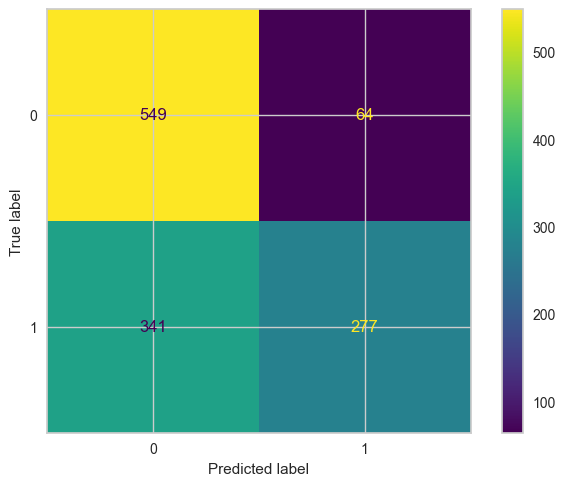

Confusion Matrix Случайный лес


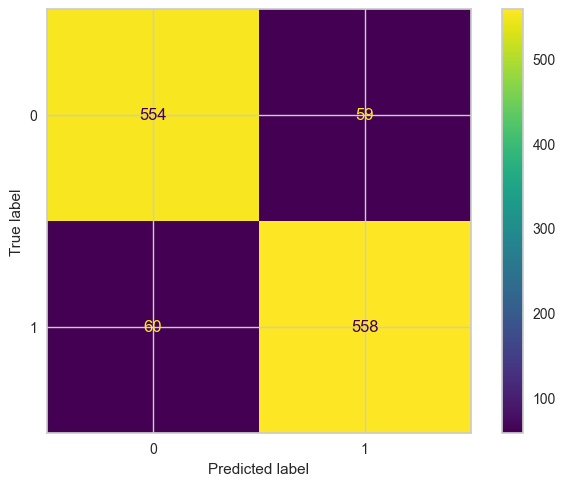

Confusion Matrix Градиентный бустинг


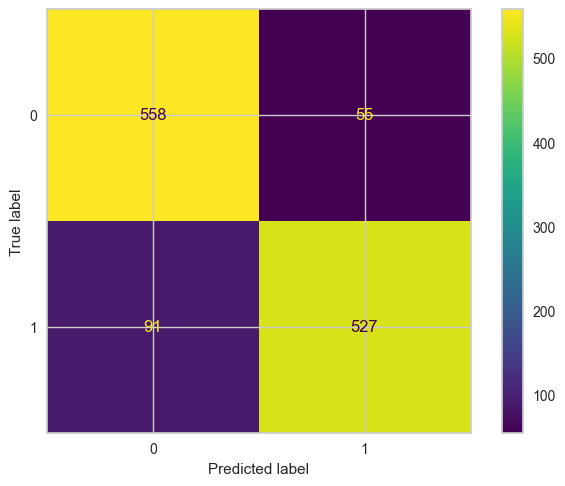

Confusion Matrix Логистическая регрессия


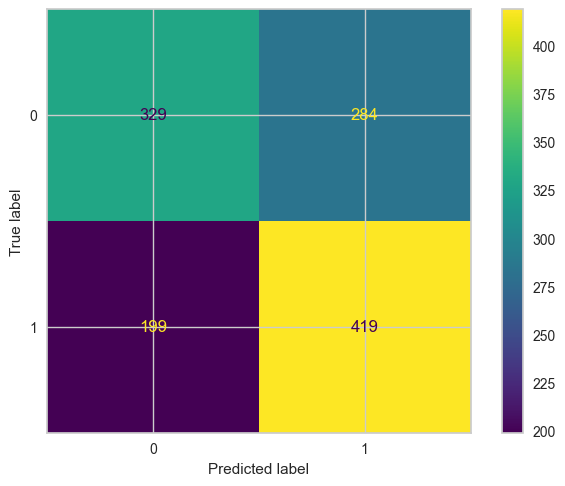

In [93]:
#Перед тем, как считать метрики посмотрим на Confusion Matrix

#Дерево
print('Confusion Matrix Дерево решений')
cm_tree = confusion_matrix(y_test, Y_tree_tst, labels=model_tree.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=model_tree.classes_)
disp_tree.plot()
plt.show()

#Случайный лес
print('Confusion Matrix Случайный лес')
cm_rf = confusion_matrix(y_test, Y_rf_tst, labels=model_rf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=model_rf.classes_)
disp_rf.plot()
plt.show()

#Градиентный бустинг
print('Confusion Matrix Градиентный бустинг')
cm_gb = confusion_matrix(y_test, Y_gb_tst, labels=model_gb.classes_)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=model_gb.classes_)
disp_gb.plot()
plt.show()

#Логистическая регрессия
print('Confusion Matrix Логистическая регрессия')
cm_logreg = confusion_matrix(y_test, Y_logreg_tst, labels=model_logreg.classes_)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=model_logreg.classes_)
disp_logreg.plot()
plt.show()

In [94]:


TREE_CLR=classification_report(y_test,Y_tree_tst)
print("Метрики Деревья решений на тестовой выборке")
print(TREE_CLR)

RF_CLR=classification_report(y_test,Y_rf_tst)
print("Метрики Случайный лес на тестовой выборке")
print(RF_CLR)

GB_CLR=classification_report(y_test,Y_gb_tst)
print("Метрики Градиентный бустинг на тестовой выборке")
print(GB_CLR)

LOGREG_CLR=classification_report(y_test,Y_gb_tst)
print("Метрики Логистическая регрессия на тестовой выборке")
print(LOGREG_CLR)

Метрики Деревья решений на тестовой выборке
              precision    recall  f1-score   support

           0       0.62      0.90      0.73       613
           1       0.81      0.45      0.58       618

    accuracy                           0.67      1231
   macro avg       0.71      0.67      0.65      1231
weighted avg       0.71      0.67      0.65      1231

Метрики Случайный лес на тестовой выборке
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       613
           1       0.90      0.90      0.90       618

    accuracy                           0.90      1231
   macro avg       0.90      0.90      0.90      1231
weighted avg       0.90      0.90      0.90      1231

Метрики Градиентный бустинг на тестовой выборке
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       613
           1       0.91      0.85      0.88       618

    accuracy                           0.88     

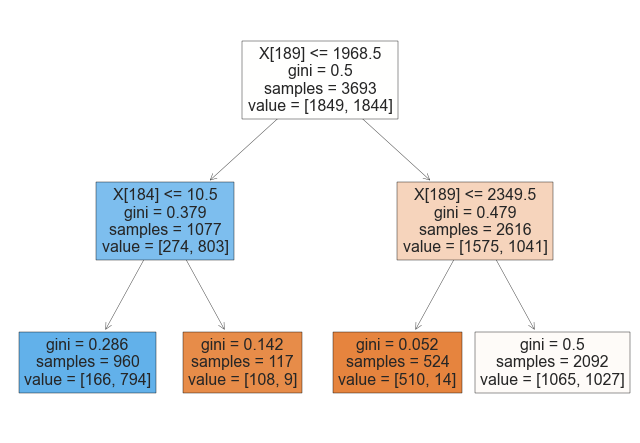

In [95]:
#Визуализация дерева
tree.plot_tree(model_tree, filled='True')
plt.show()

МЫ построили древо и узнали признаки, которые определяют нашу классификацию

# Catboostclassifier

In [96]:
clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    loss_function='CrossEntropy'
)

In [97]:
clf.fit(X_train, y_train,         
        eval_set=(X_test, y_test), 
        verbose=False
)

# Точность на обучающей и тестовой выборке (средняя)

In [98]:
val_score = clf.score(X_test, y_test) # val (test) score
train_score = clf.score(X_train, y_train) # train (learn) score

val_score,train_score

(0.8456539398862714, 0.8334687246141349)

In [99]:
cat_pr = clf.predict(X_test)

# Проверим catboost classifier

In [100]:
d = {'day':y_test}
Predict_test = pd.DataFrame(data=d)
Predict_test['predict'] = cat_pr
print('Верно спрогнозированное событие, %: ', len(Predict_test[(Predict_test['predict'] == 1)&(Predict_test['day'] == 1)].index)/len(Predict_test[Predict_test['day'] == 1].index))
print('Верно спрогнозированное отсуствие события, %: ', len(Predict_test[(Predict_test['predict'] == 0)&(Predict_test['day'] == 0)].index)/len(Predict_test[Predict_test['day'] == 0].index))

Верно спрогнозированное событие, %:  0.8543689320388349
Верно спрогнозированное отсуствие события, %:  0.8368678629690048


Вывод: предложенная нами модель оценки построенной классификации почти совпадает с общепринятыми стандартами машинного обучения. Построенные классификации имеют f1-score выше 0.8